In [1]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *
import math
from sklearn.metrics import mean_squared_error as MSE
import xarray as xr

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats
from hydroeval import *
import seaborn as sns
import pwlf
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm
import pickle

def cm2inch(*tupl):### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
import warnings
warnings.filterwarnings("ignore")

years = [2016, 2017, 2018]

In [112]:
# (141+239+150)/(330+603+301)

In [113]:
# len(df_agg),len(df_agg.gpr[np.isnan(df_agg.gpr)].values)

In [111]:
# d=df_agg[(df_agg.id==4)];dist=d.distance[np.isnan(d.gpr)].values;
# x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
# coefficients = np.polyfit(x, y,5); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
# new_y = poly(new_x);fill=poly(dist);plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
# # for f in range(len(dist)):
# #     df_agg.gpr[(df_agg.id==4)&(df_agg.distance==dist[f])]=fill[f]

Mean Vel. vz 13.74 10.07
Mean Vel. ITS 9.62 7.59
3.8659275
2.8035376
Original vector layer projection:  {'init': 'epsg:32611'}
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:2955


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  +init=epsg:2955
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
OBSFG work start
OBSFG work end
sl [0.01625115 0.0044189 ]
sl [0.00548912 0.01815692]
sl [0.0068493  0.01711697]
sl [0.00774965 0.01221702]
slope RLM: 0.012803444715552302
s

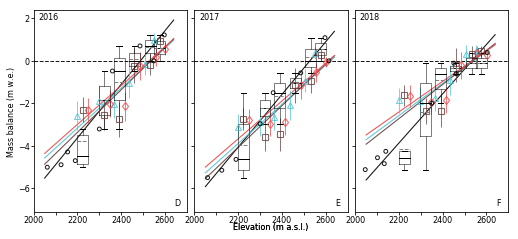

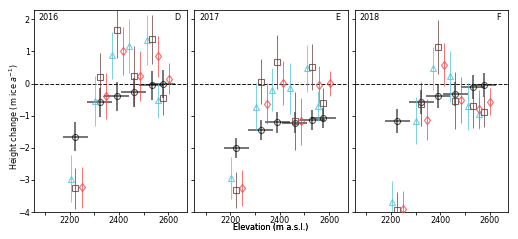

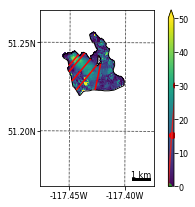

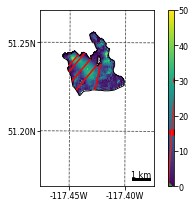

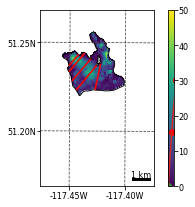

In [5]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8};plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'; pylab.rcParams['ytick.major.pad']='1.'

fig1, ax1 = plt.subplots(1,3, sharex=True, sharey=True, figsize=(cm2inch(18, 8.))) #obs. and flux gate SMB boxplot/errorbar plot
fig2, ax2 = plt.subplots(1,3, sharex=True, sharey=True, figsize=(cm2inch(18, 8.))) ##mass conservation plot
count = 0
mfc='none'; mew=1.1; elw=0.9

for yr in range(len(years)):
    # season
    balance = 'Ba'  # Bw or Ba (winter or annual)
    # rho_snow = 445. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
    year = years[yr]
    I = np.abs(year - 2016) # for selecting raster inputs
    vcorr=False ## is velocity corrected by off ice bias and stake bias?

    gl = 2 # number to select glacier
    Glacier = ['Kokanee', 'Conrad', 'Illecillewaet']
    glacier = ['kokanee', 'conrad', 'illecillewaet']
#     d = 20. #20.  #distance (m) between flux gate points
    Dint = 0.85 #depth integrated velocity ratio, 1.0= all sliding
    sVSTAKE=1.10; sVOFFice=1.1; sVCoreg=2.0; sVRAND=1.5
    sVsys=np.sqrt((sVOFFice**2)+(sVCoreg)**2)
    sVZ=np.sqrt((sVsys**2)+((sVRAND)**2))
    sHopt = 0.078 ## ME:10.3 m,  MAE:0.223 (percent ratio)

    fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
    gpr_path = '/home/pelto/GIS/GPR/ComparisonData/'
    path = '/home/pelto/Desktop/lidar_cbt_analysis/' + glacier[gl] + '/'

    VDIR = 'individual'  # 'average' or 'individual'
    ITS_LIVE = True
    firn = False
    fit= 'LIN'
    
    if VDIR == 'individual':
    #     vf_list = ['img1_20160912__img1_20170917_vmap_5m_35px_spm2/', 'img1_20160912__img1_20170917_vmap_5m_35px_spm2/',
    #            'img1_20170521__img1_20180426_vmap_5m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/

#         vf_list = ['img1_20160912__img1_20170521_vmap_5m_35px_spm2/', 'img1_20160912__img1_20170521_vmap_5m_35px_spm2/',
#                'img1_20180426__img2_20181016_vmap_5m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/
        vf_list = ['illecillewaet_2016_all25m_vx.tif','illecillewaet_2017_all25m_vx.tif','illecillewaet_2018_all25m_vx.tif']
    #     vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/spm2/' + vf_list[I]
        vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/' 
#         VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
#         VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 
        VX = vdir+ vf_list[I]
        VY = vdir+ vf_list[I][:-7] + '_vy.tif' 
        ITS = fl_path + 'ITS_LIVE/' + str(year) + '_illecillewaet_ITS_LIVE.tif'
    else:
#         vf_list = ['illec_all_spm2_5m', 'illec_all_spm2_5m', 'illec_all_spm2_5m']
#         vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/spm2/'  
#         VX = vdir+ 'vx/' +vf_list[I] + '_vx.tif' 
#         VY = vdir+ 'vy/' +vf_list[I] + '_vy.tif'
        vf = 'illecillewaet_all_dem3m_'
        vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/'  
        VX = vdir + vf + 'blur1_25m_vx_neg.tif' #'vx_best_neg_5m.tif'
        VY = vdir + vf + 'blur1_25m_vy.tif'
#         VM = vdir + vf + 'vm_5m.tif'
        ITS = fl_path + 'ITS_LIVE/' + str(year) + '_illecillewaet_ITS_LIVE.tif'
    
    topo = path + '160912_illecillewaet_dem1_clip_master.tif'

    farinotti = gpr_path + glacier[gl] +'/Illec_Geike_combi.tif' #''RGI60-02/RGI60-02.03688_thickness.tif' #'RGI60-02.00147_thickness_srtm_corr.tif' #'RGI60-02/RGI60-02.00147'

    dhW_list = ['illecillewaet_2016_winter_dh_dt.tif', 'illecillewaet_2017_winter_dh_dt_dat1_clip.tif', 'illecillewaet_2018_winter_dh_dt_2.tif']
    dhA_list = ['illecillewaet_2016_2015_dh_dt_clip_filled_1617.tif', 'illecillewaet_2017_2016_dh_dt.tif','illecillewaet_2018_2017_dh_dt_zmax1800-1m.tif']
    if balance == 'Bw':
        dh_r = path+ dhW_list[I]   #winter height change TIFF
    else:
        dh_r = path+  dhA_list[I] #Annual height change TIFF

    pts_file = fl_path + 'Illec_flux_gates_5_pts_20m.shp'  ##must be WGS84 currently
    gates = fl_path+'Illec_flux_gates_5.shp'
    shpf = '/home/pelto/GIS/outlines/Illec2016.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 

    if year==2016 or year==2017:
        bins=fl_path+'illec_flux_bins_16_5.shp'
    else:
        bins=fl_path+'illec_flux_bins_17_5.shp'

    obs = pd.read_csv(fl_path+ 'Illecillewaet_bdot.csv')
    rho = pd.read_csv(fl_path + 'illec_rho_5.csv')  ## rho

    # open GeoTIFF as array
    vx = salem.open_xr_dataset(VX);vy = salem.open_xr_dataset(VY);vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
    msk = salem.open_xr_dataset(fl_path + 'illec_all_glaciers_2016.tif') 
    extent=salem.open_xr_dataset(path +'illecillewaet_2014_extent_5m.tif') ## 1.0 for glacier nan for off (-9999)
    
    # msk = msk.to_array(name='msk')
    gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
    farin = salem.open_xr_dataset(farinotti)

    H_opt = salem.open_xr_dataset(fl_path+'Illecillewaet_251sw_MAE_optimized.tif')#+'Illecillewaet101sw_MAE_optimized.tif') 
 
    gates = salem.read_shapefile(gates)
    H_opt_reproj = vx.salem.transform(H_opt); H_opt = H_opt_reproj.to_array(name='H_opt')
    msk_reproj = vx.salem.transform(msk);msk = msk_reproj.to_array(name='msk')
    extent_reproj=vx.salem.transform(extent); extent = extent_reproj.to_array(name='extent')
    gpr_reproj = vx.salem.transform(gpr); gpr = gpr_reproj.to_array(name='gpr')
    ITS = salem.open_xr_dataset(ITS); ITS_reproj = vx.salem.transform(ITS);ITS = ITS_reproj.to_array(name='ITS')

    farin_reproj= vx.salem.transform(farin)
    farin = farin_reproj.to_array(name='farin')
    srtm_corr = fl_path + 'illecillewaet_SRTM_diff_30m.tif'
    srtm_corr = salem.open_xr_dataset(srtm_corr);srtm_corr = vx.salem.transform(srtm_corr)
    srtm_corr = srtm_corr.to_array(name='srtm_corr')
    srtm_corr.data[srtm_corr.data>10.0] = 0.0  ##remove positive anomalous values
    srtm_corr.data[srtm_corr.data<-50.0] = 0.0 ##remove negative anomalous values
    farin_corr = farin + srtm_corr; farin_corr= farin_corr.rename('farin_corr')

    gpr.data[gpr.data<0] = np.nan
    gpr.data[gpr.data<1.5] = 0.0   #not having any effect
#     VZ = np.sqrt(vx.data**2 + vy.data**2 )
    vx.data[vx.data>0.01]= vx.data[vx.data>0.01]*-1.0 #=np.nan  ## vx for illec
    vz = vy.copy(); vz.data = np.sqrt(vx.data**2 + vz.data**2 )
    vz.data[extent.data!=1.0] = np.nan;vx.data[extent.data!=1.0] = np.nan;vy.data[extent.data!=1.0] = np.nan 
    vz=xr.DataArray(vz.data, coords=vz.coords, name='vz')
    np.savetxt(fl_path+(str(year)+'_vz.csv'), vz[0].data, delimiter=',')
    ITS.data[extent.data!=1.0] = np.nan
    VZ_off_ice = vz.copy()
    VZ_off_ice.data[msk.data==1.0] = np.nan
    # VZ_off_ice[VZ_off_ice==0.0] = np.nan  ## vz[extent.data<1.0] = np.nan
    
    with open(fl_path+str(year)+'_vz.pkl', 'wb') as f:
        pickle.dump(vz[0].data, f)
    with open(fl_path+str(year)+'_ITS.pkl', 'wb') as f:
        pickle.dump(ITS[0].data, f)
    
    DIFF = vz - ITS
    dem = salem.open_xr_dataset(topo)
    dem_reproj = vx.salem.transform(dem)
    dem = dem_reproj.to_array(name='dem')
    dem.data[dem.data<1] = np.nan

    #     # map extent
    # grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
    # 487892.000 5509738.000 491232.000 5512358.000
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(cm2inch(18, 8.25))) 
    grid = vx.salem.grid  ##full view
    sm = Map(grid, countries=False)
    sm.set_lonlat_contours(interval=0)
    sm.set_scale_bar()
    sm.set_data(vz) #, label='m')
    sm.set_vmax(val=50.)
    #      Change the lon-lat countour setting
    sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
    off_ice_V = np.nanmean(VZ_off_ice)
    print('Mean Vel. vz', round(np.nanmean(vz),2), round(np.nanstd(vz),2))
    print('Mean Vel. ITS', round(np.nanmean(ITS),2), round(np.nanstd(ITS),2))
    print(off_ice_V)
    print(np.nanstd(VZ_off_ice))
    gdf = salem.read_shapefile(shpf)
    sm.set_shapefile(gdf, linewidth=1)
    sm.set_shapefile(gates, linewidth=1.5, color='r')
    sm.visualize()
    #     plt.savefig(fl_path+ 'products/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
    #     plt.show()

    ## Functions for calculating zonal statistics over each flux gate bin
    # https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
    # For loading shapefiles into geopandas dataframe

    def enum_items(source):
        print("\n")
        for ele in enumerate(source): 
            print(ele)

    def list_columns(df):
        field_list = list(df)
#         enum_items(field_list)
        return field_list

    def loadshp_as_gpd(shp):
        data_shp = gpd.read_file(shp)
        return data_shp

    # For loading feature classes into geopandas dataframe
    def loadfc_as_gpd(fgdb):
        layers = fiona.listlayers(fgdb)
        enum_items(layers)
        index = int(input("Which index to load? "))
        fcgpd = gpd.read_file(fgdb,layer=layers[index])
        return fcgpd

    # For re-projecting input vector layer to raster projection
    def reproject(fcgpd, raster):
        proj = raster.crs.to_proj4()
        print("Original vector layer projection: ", fcgpd.crs)
        reproj = fcgpd.to_crs(proj)
        print("New vector layer projection (PROJ4): ", reproj.crs)
    #     fig, ax = plt.subplots(figsize=(15, 15))
    #     rplt.show(raster, ax=ax)
    #     reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    #     fig.show()
        return reproj

    def dissolve_gpd(df):
        field_list = list_columns(df)
        index = 1 #int(input("Dissolve by which field (index)? "))
        dgpd = df.dissolve(by=field_list[index])
        return dgpd

    # For selecting which raster statistics to calculate
    def stats_select():
        stats_list = stats_list = ['min', 'max', 'mean', 'count', 
                  'sum', 'std', 'median', 'majority', 
                  'minority', 'unique', 'range']
        enum_items(stats_list)
    #     indices = input("Enter raster statistics selections separated by space: ")
        indices='2 3 5 6'
        stats  = list(indices.split())
        out_stats = list()
        for i in stats:
            out_stats.append(stats_list[int(i)])
        return out_stats

    def get_zonal_stats(vector, raster, stats):
        # Run zonal statistics, store result in geopandas dataframe
        result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
        geostats = gpd.GeoDataFrame.from_features(result)
        return geostats

    df = salem.read_shapefile(pts_file); df_file = loadshp_as_gpd(pts_file); df_file.crs

    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]; df['lat'] = coords[:, 1]

    # ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
    xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx; df['y'] = yy

    vns = ['vx','vy','vz','ITS','gpr','H_opt','dem','farin_corr',]

    M = xr.merge([vx,vy,vz,ITS,gpr,H_opt,dem,farin_corr])

    for vn in vns:
        df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

    df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
    ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
    df_agg['i'] = ii; df_agg['j'] = jj
    # # We trick by creating an index of similar i's and j's
    df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii.astype(int), jj.astype(int))]
    df_agg = df_agg.groupby('ij').mean()
    # Select
    for vn in vns:
        df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i.astype(int)), y=('z', df_agg.j.astype(int)))  

    D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'vz', 'ITS','gpr', 'H_opt', 'dem', 'farin_corr']].copy()
    #     D = D[D.id!='0122_0084'] # removing a magical duplicate point
    #     D.reset_index(inplace=True,drop=True);
    #         print('starting vel work')
#     for i in range(len(D)):
#         if D.vx[i]>20:
#             D.vx[i]=D.vx[i]/-2
#         elif D.vx[i] > 0.0 and D.vx[i] < 20:
#             D.vx[i]=D.vx[i]/-1
#         elif D.distance[i]==0.0 or D.distance[i]==D.len[i]:
#             D.vx[i] = 0.0;D.vy[i] = 0.0
#     print('ending vel work')        
    #D['vz'] = #np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )
    D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
    
    ## fill missing IPR data
    ipr=D[(D.id==0)&(D.distance>300.)&(D.distance<900.)];dist=ipr.distance[np.isnan(ipr.gpr)].values  
    x=ipr.distance[np.logical_not(np.isnan(ipr.gpr))].values;y=ipr.gpr.values; y=y[np.logical_not(np.isnan(y))]
    coefficients = np.polyfit(x, y, 2); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.id==0)&(D.distance==dist[f])]=fill[f]

    ipr=D[(D.id==1)&(D.distance<600)];dist=ipr.distance[np.isnan(ipr.gpr)].values;
    x=ipr.distance[np.logical_not(np.isnan(ipr.gpr))].values;y=ipr.gpr.values; y=y[np.logical_not(np.isnan(y))]
    fill=poly(dist);coefficients = np.polyfit(x, y, 3); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.id==1)&(D.distance==dist[f])]=fill[f]

    ipr=D[(D.id==3)];dist=ipr.distance[np.isnan(ipr.gpr)].values;
    x=ipr.distance[np.logical_not(np.isnan(ipr.gpr))].values;y=ipr.gpr.values; y=y[np.logical_not(np.isnan(y))]
    fill=poly(dist)
    coefficients = np.polyfit(x, y, 5); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
    new_y = poly(new_x);fill=poly(dist);#plt.scatter(dist,fill,color='r');plt.plot(x, y, "o", new_x, new_y)
    for f in range(len(dist)):
        D.gpr[(D.id==3)&(D.distance==dist[f])]=fill[f]

    D.gpr[(D.id==2)&(D.distance==0.0)]=48.3;D.gpr[(D.id==2)&(D.distance==20.0)]=27.9;D.gpr[(D.id==2)&(D.distance==40.0)]=47.5
    ct=0;depth=[191.8717,196.46,200.7749,204.8164,208.5844,212.0791,215.3003,218.2481,220.9225,223.3235,225.4511,227.3052,228.886,230.1933,231.2272]
    for i in range(460,760,20):
        D.gpr[(D.id==4)&(D.distance==float(i))]=depth[ct]
        ct+=1
    ct=0;depth2=[231.6889,230.8089,229.6555,228.2286,226.5284,224.5547,222.3077,219.7872,216.9933,213.9259,210.5852,
                206.971,203.0835,198.9225,194.4881,189.7803,184.799,179.5444,174.0163,168.2149,162.14]
    for i in range(860,1280,20):
        D.gpr[(D.id==4)&(D.distance==float(i))]=depth2[ct]
        ct+=1
    if year==2018: 
        with open(fl_path + glacier[2]+'_df_agg.pkl', 'wb') as f:
            pickle.dump(D, f)    
    #multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
    if ITS_LIVE == True:
        D['vfg'] = D.ITS
    else:
        D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice    
    
    for i in range(len((D))):   #D.id.nunique()):
        if np.isnan(D.vfg[i])==True:
            G=D.id[i]
            V=np.nanmean(D.vfg[D.id==G]) 
            D.vfg[i]=V
    with open(fl_path + str(year)+'_Dvfg.pkl', 'wb') as f:
        pickle.dump(D.vfg.values, f)      
    dem_r = topo;vel_r = VX ;shp = loadshp_as_gpd(bins)
    rasters = [dh_r, dem_r, vel_r]
    names = ['dh','dem','vx']
    for i in range(len(rasters)):
        raster = rasters[i]
        rst = rasterio.open(raster)
        shp = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
        name = names[i]
    #     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
        stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
        ZS = (get_zonal_stats(shp, raster, stats))
        ZS.drop(['geometry'], axis=1, inplace=True)
        ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
        ZS.sort_values(by=['bin'],ascending=True, inplace=True)
        ZS.set_index('bin', inplace=True)
        if i == 0:
            ZS_df = ZS
        else:
            ZS_df = pd.concat([ZS_df, ZS], axis=1)
            
############ correct ice thickness for thinning ##############  
    D1=D.copy(); D1.reset_index(inplace=True,drop=True);DH=[]
    for i in range(len(D1)):
        fl_id=D1.loc[i].id
        if year == 2016:
            del_h= ZS_df.loc[fl_id].dh_mean * -1##increase thickness to represent 2015 ice srfc
        elif year == 2017:
            del_h=0.0 ## no change current 2018 ice measurments map 2016 ice surface (2017 srfc+winter SD)
        elif year == 2018:
            del_h=new17.loc[fl_id].dh_mean
        DH.append(del_h)

    D['DH']=DH
    D.H_opt = D.H_opt + D.DH
    D.H_opt[D.H_opt<0.] = 0.0
    D.gpr = D.gpr + D.DH 
    D.gpr[D.gpr<0.] = 0.0
    D.farin_corr = D.farin_corr + D.DH
    D.farin_corr[D.farin_corr<0.] = 0.0
########### end correct ice thickness for thinning ##############
    
    D.sort_values(by=['distance','id'],ascending=[True,True], inplace=True) 
    
    for n in range(D.id.nunique()):

        for c in range(len(D.id[D.id==n])): #.count()-1)#range(D.id[D.id==n].count()-1):
            idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index

            if c==0:  ## first point in line
                L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c]
                G= L * D.H_opt[D.id==n][c+1]*0.5;J= L * D.farin_corr[D.id==n][c+1]*0.5 #area of triangle
                 
            elif c==1: #second point from start
                L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2
                G= L * D.H_opt[D.id==n][c]; J= L * D.farin_corr[D.id==n][c]
                 
            elif c==len(D.id[D.id==n])-2: #second to last point
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 
                G= L * D.H_opt[D.id==n]; J= L * D.farin_corr[D.id==n]
                
            elif c==len(D.id[D.id==n])-1:  #last point in line
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])
                G= L * D.H_opt[D.id==n][c-1]*0.5; J= L * D.farin_corr[D.id==n][c-1]*0.5 #area of triangle
                
            else:
                L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                        D.distance[D.id==n][c-1])/2))
                G=L* D.H_opt[D.id==n][c] ; J=L* D.farin_corr[D.id==n][c]  
                
            D.loc[idx,'A_Hopt']= G;D.loc[idx,'A_farin']= J; D.loc[idx,'Len_mod']= L     
    D_all=D.copy()
#     KP=[];KF=[]
#     for loop in D.index:
#         id= D[D.index==loop].id.values
#         KP.append((D[D.index==loop].vfg * Dint * d * D.H_opt[D.index==loop]).values[0])  ## ice flux per slice *0.9 to est. depth-integrated velocity
#         KF.append((D[D.index==loop].vfg * Dint * d * D.farin_corr[D.index==loop]).values[0])
#     D['Qopt'] = KP;D['Qfarin'] = KF
    D['Qopt'] = D.A_Hopt * (D.vfg) * Dint;D['Qfarin'] = D.A_farin * (D.vfg) * Dint    

    ### Uncertainties
    D['sQout'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*Dint) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQout_low'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*0.80) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQout_high'] = np.sqrt((sVZ * D.A_Hopt)**2 + ((D.vfg*1.00) * D.Len_mod * (sHopt*D.H_opt))**2)
    D['sQoutF'] = np.sqrt((sVZ * D.A_farin)**2 + ((D.vfg*Dint) * D.Len_mod * (sHopt*D.farin_corr))**2)

    Q_out= [0.,] #flux out per gate
    cr_area = [0.,] # cross-section area per gate
    vzdir = [0.,]; sQout= [0.,];sQout_low= [0.,];sQout_high= [0.,];vfg_all=[];gate_elev=[];v_gate_mean=[];
    Len_mod=[0.,];gate_width=[0.,]
    
    for n in range(D.id.nunique()):
        vfg_all.append(D.vfg[D.id==n])
        gate_elev.append(D.dem[D.id==n].mean())
    
    for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.A_Hopt[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean());gate_width.append(D.len[D.id==n].max())
        sQout.append(D.sQout[D.id==n].sum());sQout_low.append(D.sQout_low[D.id==n].sum()); sQout_high.append(D.sQout_high[D.id==n].sum()) 
        v_gate_mean.append(D.vfg[D.id==n].mean());Len_mod.append(D.Len_mod[D.id==n].sum())

    Q_in = [Q_out[1:]]
    sQin = [sQout[1:]+ [0.0]];sQin_low = [sQout_low[1:]+ [0.0]];sQin_high = [sQout_high[1:]+ [0.0]]    
    Q_in = np.squeeze(Q_in); sQin = np.squeeze(sQin);sQin_low = np.squeeze(sQin_low);sQin_high = np.squeeze(sQin_high)

    Q_outF= [0.,]; cr_areaF = [0.,]; sQoutF = [0.,]
    for n in range(D.id.nunique()+1):
            Q_outF.append(D.Qfarin[D.id==n].sum()) 
            cr_areaF.append(D.A_farin[D.id==n].sum()) 
            sQoutF.append(D.sQoutF[D.id==n].sum())

    Q_inF = [Q_outF[1:]] #flux in per bin
    Q_inF = np.squeeze(Q_inF)
    sQinF = [sQoutF[1:]+ [0.0]]; sQinF = np.squeeze(sQinF)

    FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, sQout, sQout_low, sQout_high, sQin, sQin_low, sQin_high, Q_outF, Q_inF, sQoutF, sQinF, cr_areaF, vzdir,Len_mod, gate_width)), 
            columns=['Q_out', 'Q_in', 'cr_area', 'sQout', 'sQout_low', 'sQout_high', 'sQin', 'sQin_low', 'sQin_high', 'Q_outF', 'Q_inF','sQoutF', 'sQinF', 'cr_areaF', 'vzdir','Len_mod','gate_width']) 

    FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
    FG['vfgF'] = FG.Q_outF / FG.cr_area
    FG['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)
     
    FG['spQout'] = FG.sQout / FG.Q_out * 100. #%err on flux
    FG['spQin'] = FG.sQin / FG.Q_in * 100. #%err on flux
    FG['spQoutF'] = FG.sQoutF / FG.Q_outF * 100. #%err on flux
    FG['spQinF'] = FG.sQinF / FG.Q_inF * 100. #%err on flux

    ### import data per bin: height change, elevation, surface area, obs.SMB etc. 
    FG_df = FG.copy(); FG_df =  pd.concat([FG_df, ZS_df], axis=1)
    rho.sort_values(by='bin',ascending=True, inplace=True) # sort by bin
    rho.set_index('bin', inplace=True) # set bin as index for sorting
    FG_df =  pd.concat([FG_df, rho], axis=1)

    WR= np.array(FG_df.dem_count[1:]); WR= np.append(WR,[0])

    FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
    FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count

    FG_df['Q_netF'] = FG_df.Q_inF - FG_df.Q_outF  #net flux per gate
    FG_df['Q_netAF']= FG_df.Q_netF / FG_df.dem_count

    FG_df['area_Qin']= WR
    FG_df['sQoptA'] = FG_df.sQout / FG_df.dem_count
    FG_df['sQoptA_low'] = FG_df.sQout_low / FG_df.dem_count;FG_df['sQoptA_high'] = FG_df.sQout_high / FG_df.dem_count    
    FG_df['sQ_inA'] = FG_df.sQin / (FG_df.area_Qin+0.001)
    FG_df['sQ_inA_low'] = FG_df.sQin_low / (FG_df.area_Qin+0.001);FG_df['sQ_inA_high'] = FG_df.sQin_high / (FG_df.area_Qin+0.001)
    FG_df['sQnetA_opt'] = np.sqrt(FG_df.sQoptA**2 + FG_df.sQ_inA**2)
    FG_df['sQnetA_opt_low'] = np.sqrt(FG_df.sQoptA_low**2 + FG_df.sQ_inA_low**2);FG_df['sQnetA_opt_high'] = np.sqrt(FG_df.sQoptA_high**2 + FG_df.sQ_inA_high**2)

    FG_df['sQoutFA'] = FG_df.sQoutF / FG_df.dem_count
    FG_df['sQ_inFA'] = FG_df.sQinF / (FG_df.area_Qin+0.001)
    FG_df['sQnetFA'] = np.sqrt(FG_df.sQoutFA**2 + FG_df.sQ_inFA**2)
    
    ##calculate height change due to mass balance for highest bins considering firn compaction
    if firn == False:
        FG_df.Vfirn = 0.0
    FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA + FG_df.Vfirn
    FG_df['b_fg_hF'] = FG_df.dh_mean - FG_df.Q_netAF + FG_df.Vfirn

     ## Ilec slope, constant: (0.025293682808396056, 400.09590745271896)
#     FG_df['rho_snow'] = (FG_df.dem_mean*(-0.02529))+400.095  #*-0.11255+743.22)
    for r in range(len(FG_df.dem_count)):  ## set density of mass change to density of snow if Bn>0.0 (Pelto et al. (2019))
        if FG_df.b_fg_h[r] < 0.0:
            FG_df['rho_%s'%year][r]=FG_df['rho_%s'%year][r]
        else:
            FG_df['rho_%s'%year][r]=572.
            
    if balance == 'Bw':
        FG_df['b_fg_we'] = FG_df.rho_snow/1000 * FG_df.b_fg_h
    else:
        FG_df['b_fg_we'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_h

    if balance == 'Bw':
        FG_df['b_fg_weF'] = FG_df.rho_snow/1000 * FG_df.b_fg_hF
    else:
        FG_df['b_fg_weF'] = FG_df['rho_%s'%year]/1000. * FG_df.b_fg_hF

    ### Uncertainties
    if I==0:
        sDHdt = 0.45 #0.04 #m Bias dh from Pelto et al. 2019
    if I==1:
        sDHdt = 0.32
    elif I==2:
        sDHdt = 0.38
        
    sVfirn = 0.10; sRHO = 0.10 #0.05 # percent uncertainty in density

    FG_df['sDH_opt'] = np.sqrt(sDHdt**2 + (FG_df.sQnetA_opt)**2 + (FG_df.Vfirn*sVfirn)**2)
    FG_df['sBwe_opt'] = np.sqrt((FG_df.sDH_opt * (FG_df['rho_%s'%year]/1000.))**2+
                   (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

    FG_df['sDH_F'] = np.sqrt(sDHdt**2 + (FG_df.sQnetFA)**2 + (FG_df.Vfirn*sVfirn)**2)
    FG_df['sBwe_F'] = np.sqrt((FG_df.sDH_F * (FG_df['rho_%s'%year]/1000.))**2+
                   (FG_df.dh_mean * (FG_df['rho_%s'%year]/1000.*sRHO))**2)

    D['Agpr']=np.NaN;D = D.dropna(subset=['gpr'])
    D.sort_values(by=['distance','id'],ascending=[True,True], inplace=True) 
    
    
    for i in range(len((D))):   #D.id.nunique()):
        if np.isnan(D.vz[i])==True:
            G=D.id[i]
            V=np.nanmean(D.vz[D.id==G])
            D.vz[i]=V
    
    for n in range(D.id.nunique()):
  
        for c in range(len(D.id[D.id==n])):
            idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index

            if c==0: ## first point in line
                L= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] 
                G= L * D.gpr[D.id==n][c+1]#*0.5 #area of triangle
            elif c==1: #second point from start
                L= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 
                G= L * D.gpr[D.id==n][c]
            elif c==len(D.id[D.id==n])-2: #second to last point
                L= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2
                G= L * D.gpr[D.id==n]
            elif c==len(D.id[D.id==n])-1:  #last point in line
                L= D.distance[D.id==n][c] - D.distance[D.id==n][c-1] 
                G= L * D.gpr[D.id==n][c-1]*0.5 #area of triangle
            else:
                L=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                        D.distance[D.id==n][c-1])/2))
                G= L * D.gpr[D.id==n][c]  
            D.loc[idx,'Agpr']= G; D.loc[idx,'Len_gpr']= L          

    #calculate flux out using GPR thicknesses
    sGPR = 0.0516 #gpr error %
    D['sInterp_gpr'] = np.nan
    for n in range(len(D.Len_gpr)):
        if D.Len_gpr[n] > 50.:
            D.sInterp_gpr[n] = D.gpr[n] * 0.10  
        else: 
            D.sInterp_gpr[n] = 0.0
    sH_gpr = np.sqrt(D.sInterp_gpr**2+ (D.gpr*sGPR)**2)

    D['Qo_gpr'] = D.Agpr * (D.vfg) * Dint#* 0.9
    D['sQo_gpr'] =  np.sqrt((sVZ * (D.gpr) * D.Len_gpr)**2 + ((D.vfg*Dint) * D.Len_gpr * (sH_gpr))**2)

    Qo_gpr = [0.,] #flux out per gate
    cr_area_gpr = [0.,] # cross-section area per gate
    vzdir_gpr = [0.,]; sQo_gpr= [0.,];Len_gpr=[0.,]
    for n in range(D.id.nunique()):
            Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
            cr_area_gpr.append(D.Agpr[D.id==n].sum())
            vzdir_gpr.append(D.vzdir[D.id==n].mean())
            sQo_gpr.append(D.sQo_gpr[D.id==n].sum())
            Len_gpr.append(D.Len_gpr[D.id==n].sum())
    Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
    Qin_gpr = np.squeeze(Qin_gpr)
    sQin_gpr = [sQo_gpr[1:]+ [0.0]]
    sQin_gpr = np.squeeze(sQin_gpr)

    FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr, sQo_gpr,sQin_gpr,Len_gpr)), 
                          columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr', 'sQo_gpr','sQin_gpr','Len_gpr']) 
    FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
    # FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
    # FG['bin']=np.arange(0,14,1)
    FG_gpr['spQo_gpr'] = FG_gpr.sQo_gpr / FG_gpr.Qo_gpr * 100. #%err on flux
    FG_gpr['spQin_gpr'] = FG_gpr.sQin_gpr / FG_gpr.Qin_gpr * 100. #%err on flux 

    FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  
    # FG_all
    FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
    FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count 
    FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr +FG_all.Vfirn #dh1516_mean

    FG_all['sQoutA_gpr'] = FG_all.sQo_gpr / FG_all.dem_count
    FG_all['sQ_inA_gpr'] = FG_all.sQin_gpr / (FG_all.area_Qin+0.001)
    FG_all['sQnetA_gpr'] = np.sqrt(FG_all.sQoutA_gpr**2 + FG_all.sQ_inA_gpr**2)

    if balance == 'Bw':
        FG_all['b_fg_we_gpr'] = FG_df.rho_snow/1000. * FG_all.b_fg_h_gpr
    else:
        FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
    # FG_all.drop(FG_all.tail(1).index,inplace=True)

    FG_all['sDH_gpr'] = np.sqrt(sDHdt**2 + (FG_all.sQnetA_gpr)**2 + (FG_all.Vfirn*sVfirn)**2)
    FG_all['sBwe_gpr'] = np.sqrt((FG_all.sDH_gpr * (FG_all['rho_%s'%year]/1000.))**2+
                   (FG_all.dh_mean * (FG_all['rho_%s'%year]/1000.*sRHO))**2)

    ## Plot balance gradients
    n = 0
    s= 15 #markersize
    a = 0.9
    color=['b', 'lime', 'green', 'teal']

    ##all_obs
    if balance == 'Bw':
        obs = obs.dropna(subset=['Bw'])
        y_ax_obs=obs[(obs.Year==year)].Bw

    else:
        obs = obs.dropna(subset=['Ba'])
        y_ax_obs=obs[(obs.Year==year)].Ba


    x_ax_obs=obs[(obs.Year==year)].Elev

    # Drop unrealistic FG smb:
    new = FG_all.copy() 
           
    yerr = [0.0, new.sBwe_gpr , new.sBwe_opt, new.sBwe_F] #new.sBwe_gpr
    new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
    xerr = new.xerr 

    x_ax_fg_gpr=new.dem_med;y_ax_fg_gpr=new.b_fg_we_gpr
    x_ax_fg_opt=new.dem_med;y_ax_fg_opt=new.b_fg_we;x_ax_fg_F=new.dem_med ;y_ax_fg_F=new.b_fg_weF
    x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt, x_ax_fg_F]
    y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt, y_ax_fg_F]
    sym = ['o', '^', 's', 'd']
    ytxt = [0.2, 0.15, 0.1, 0.05]
    letter=['D','E','F'] #['A','B','C']
    color = ['k', '#51c2d5','#663f3f','#ec4646'] #'teal', '#74c476', '#238b45']
    txt= ['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti']
    # Call function to create error bars 
    shift = [-25,0,25]
    for i in range(3):
        ax1[count].errorbar((x[i+1]+shift[i]), y[i+1], xerr=None, yerr=yerr[i+1], color=color[i+1],fmt=sym[i+1], 
                            mec=color[i+1],mfc=mfc, mew=mew, elinewidth=elw, zorder=2, label=txt[i+1], alpha=0.8) #elinewidth=0.7
        
    ## plot data and regression lines
#     if year == 2016 or year == 2017:
#     ax1[count].scatter(x[0],y[0],color=color[0], label=label[0], alpha=a, s=s,facecolor='', zorder=3)  ##plot obs data
    
    ############ obs data box plot ##################################################
#     if year != 2018:
    obs_data=obs[(obs.Year==year)]
    obs_data.reset_index(inplace=True)

    bin_size = 100.
    z_range = np.arange(2050., 2750., bin_size)
    # print(z_range)
    # obs_data['Elev_bin'] = np.nan

    i = 0
    # for n in range(len(obs_data.Ba)):
    Z_F = []; Zor_F= []; OB_F=[]

    for z in z_range: 
        W=0;bin_size = 100.; COU=1
        while W==0:
            OBS = [];Z = [];Zor = [];
            for n in range(len(new.dem_mean)):     
                if ((z - bin_size/2.) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (z + bin_size/2.)):
                    O = obs_data[balance][n]
                    Z.append(z);Zor.append(obs_data.Elev[n]);OBS.append(O)

            if len(OBS)<1 and bin_size<150:
                bin_size=bin_size*(1+(.2*COU))
                COU=COU+1    
            else:
                OB_F.append(np.array(OBS)); Z_F.append(np.array(Z));  Zor_F.append(np.array(Zor))
                W=1
        i += 1
        
    ######## OBS binned to flux bins ###########
    OB_FG=[];OB_FG_h=[];new.loc[0, 'dem_std'] = new.dem_std[0]*1.5 # lowest bin std too low for method (width-limited)
    for i in range(len(new.dem_med)): 
        f = new.dem_med[i]
        W=0;bin_size = new.dem_std[i]*2; COU=1
        while W==0:
            OBSFG = []; OBSFGh=[]
            for n in range(len(obs_data[balance])):
                if ((f - bin_size) <= obs_data.Elev[n]) and (obs_data.Elev[n] <=  (f + bin_size)):
                    O = obs_data[balance][n]
                    Oh= obs_data['Ba_h'][n]
                    OBSFG.append(O);OBSFGh.append(Oh)

#             if len(OBSFG)<2 and bin_size<150:
#                 bin_size=bin_size*(1+(.2*COU))
#                 COU=COU+1
            if len(OBSFG)<=1:
                print('OBSFG work start')
                obs_data.sort_values(['Elev'], ascending=[True],inplace=True)
                if f > (new.dem_med.min()) and f < (new.dem_med.max()):
                    down_one=OB_FG[-1][-1];down_oneH=OB_FG_h[-1][-1]
                    up_one=obs_data[obs_data.Elev> (f + bin_size/2.)]
                    up_oneH=up_one.Ba_h.iloc[0];up_one=up_one.Ba.iloc[0] #up_one=up_one.Ba[-1:]
                    OBSFG.append(down_one);OBSFG.append(up_one);  OBSFGh.append(down_oneH);OBSFGh.append(up_oneH)
                if f == (new.dem_med.max()):
                        down_one=OB_FG[-1][-1]; d2=OB_FG[-2][-2];down_oneH=OB_FG_h[-1][-1] ;d2h=OB_FG_h[-2][-2]                 
                        OBSFG.extend([down_one,d2]);OBSFGh.extend([down_oneH,d2h]);
                if f == (new.dem_med.min()):
                    up_one=obs_data[obs_data.Elev> (f + bin_size/2.)]; 
                    up_oneH=up_one.Ba_h.iloc[0];up_one=up_one.Ba.iloc[0]; #up_one=up_one.Ba[-1:]
                    OBSFG.append(up_one);  OB_FG_h.append(up_oneH)                
                print('OBSFG work end')

                OB_FG.append(np.array(OBSFG)); OB_FG_h.append(np.array(OBSFGh));
                W=1
            else:
                OB_FG.append(np.array(OBSFG));OB_FG_h.append(np.array(OBSFGh));
                W=1
                
    meanlineprops = dict(linestyle='--', lw=1., color='0.5');medianprops = dict(linestyle='-', lw=1.,color='k')
    boxprops = dict(linewidth=0.5);
#     if year == 2016 or year==2018:
#         BOX=ax1[count].boxplot(OB_F[:-1],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                        positions=[2050., 2150., 2250., 2350., 2450.,2550.],widths=50, boxprops=boxprops)
    BOX=ax1[count].boxplot(OB_FG,meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
                       positions=new.dem_med,widths=50,boxprops=boxprops,  whiskerprops=boxprops)
    #[2050., 2150., 2250., 2350., 2450., 2550., 2650.,]
#     z_range = z_range[1:] ### drop lowest bin which only has obs data
#     OB_F = OB_F[1:]
    
    GPR = [];OPT = [];FAR = []  
    for z in z_range:
        W=0; COU=1;bin_size = 100.
        while W==0:
            GG=[];PP=[];FF=[]
            ####collect balance values for each elevation bin
            for n in range(len(new.dem_med)): #for n in new.bin:  # 
                if ((z - bin_size/2.) <= new.dem_med[n]) and (new.dem_med[n] <=  (z + bin_size/2.)):
                    G = new.b_fg_we_gpr[n]
                    P = new.b_fg_we[n]
                    F = new.b_fg_weF[n]
                    GG.append(G);FF.append(F);PP.append(P)
            GG=np.array(GG)
            GG = GG[np.logical_not(np.isnan(GG))]
            
            if len(GG)<1:
                bin_size=bin_size*(1+(0.1*COU))
                COU=COU+1
                
            else:
                GPR.append(GG);OPT.append(np.array(PP));FAR.append(np.array(FF))
                W=1

################# mass conservation ####################################
  
#     for i in range(len(OB_F)):
#         B = OB_F[i].mean()
#         BM.append(B)
#     BM = np.squeeze(BM)
#     BM = {'SMB': BM}
#     BM = pd.DataFrame(data=BM, index=None)
#     new['SMB'] = BM
#     new['BMC'] = (new.SMB * new['rho_%s'%year]/1000.) + new.Q_netA + new.Vfirn 
#     new['Bdh'] = new.dh_mean   

#     new_gpr['BMC_gpr'] = (new.SMB[:-1] * new_gpr['rho_%s'%year]/1000.) + new_gpr.Q_netA_gpr + new_gpr.Vfirn 
#     new['BMCF'] = (new.SMB * new['rho_%s'%year]/1000.) + new.Q_netAF + new.Vfirn 
    
# #     new.loc[13, 'BMC_gpr'] = new.BMC[13]
#     MC = [new_gpr.BMC_gpr,new.BMC, new.BMCF]
    
    BM= []; BMh=[]
    for i in range(len(OB_FG)):
        B = OB_FG[i].mean()
        Bh = np.mean(OB_FG_h[i]) # choose median or mean
        BM.append(B);BMh.append(Bh)
    new['SMB'] = BM; new['BH']= BMh
    new['BMC'] = new.BH  + new.Q_netA     #- new.Vfirn
    new['BMC_gpr'] = new.BH + new.Q_netA_gpr# - new.Vfirn 
    new['BMCF'] = new.BH + new.Q_netAF #- new.Vfirn 
    
    MC = [new.BMC_gpr,new.BMC, new.BMCF]
    Yvv = [new.Q_netA_gpr, new.Q_netA, new.Q_netAF]
    Yvv_lbl=[r'$V^{\uparrow}_{IPR}$',r'$V^{\uparrow}_{OGGM}$',r'$V^{\uparrow}_{Farin}$']
    
    yerr_dh= [new.sBwe_gpr/(new['rho_%s'%year]/1000) , new.sBwe_opt/(new['rho_%s'%year]/1000),
              new.sBwe_F/(new['rho_%s'%year]/1000)]
    if I == 0:
        overlap=[];overlap_gpr=[];overlapF=[]
        MC_LIST=[overlap_gpr,overlap,overlapF]
        
    for i in range(3):
#         ax2[count].scatter(new.dem_med, Yvv[i], edgecolor='r', marker='^', alpha=0.8, label=Yvv_lbl[i], s=s+12, 
#                            color=color[i+1], zorder=4, linewidth=0.25)
        if i == 0:
            ax2[count].errorbar(new.dem_med+shift[i]+5,MC[i], xerr=None, yerr=yerr_dh[i], fmt=sym[i+1], 
                     c=color[i+1], elinewidth=elw, mew=mew, mfc=mfc,mec=color[i+1], label=txt[i+1], alpha=0.8, zorder=3)
        else:
            ax2[count].errorbar(new.dem_med+shift[i],MC[i], xerr=None, yerr=yerr_dh[i], fmt=sym[i+1], 
                     c=color[i+1], mec=color[i+1], mew=mew, mfc=mfc, elinewidth=elw, label=txt[i+1], alpha=0.8, zorder=3)
    
    ####count the number of SMB obs. +/- 1-error which fall within the uncertainty bounds of the LiDAR height change
        OL = MC_LIST[i] ## select which list to append to
        for r in range(len(MC[i])):
            M_min = MC[i][r] - yerr_dh[i][r]; M_max = MC[i][r]+ yerr_dh[i][r]
            L_min = new.dh_mean[r] - sDHdt; L_max = new.dh_mean[r] + sDHdt*2
            if M_min > L_min and M_min < L_max:
                OL.append(1);# W=0
            elif M_max < L_max and M_max > L_min:
                OL.append(1); #W=0
            elif M_max > L_max and M_min < L_min:
                OL.append(1); #W=0
            elif M_max < L_max and M_min > L_min:
                OL.append(1); #W=0
            else:
                OL.append(0)    
    
    Ybd = [BM, new.b_fg_we_gpr, new.b_fg_we, new.b_fg_weF]
    ax2[count].errorbar(new.dem_med,new.dh_mean, xerr=50, yerr=sDHdt, fmt='o', c='k', label='LiDAR',alpha=0.7, zorder=2, mfc='none')
##################Difference###########################################################
    if count == 0:
        gpr_bdiff=[];opt_bdiff=[];farin_bdiff=[];z_range_all=[];obs_all=obs_data;obs_bin_all=[];gpr_all=[];
        opt_all=[];farin_all=[];elev_all=[];gpr_bin_all=[];opt_bin_all=[];farin_bin_all=[];NSE=[];PBias=[];
        RSR=[];RSQ=[];SE=[];SL=[];ME=[];MAE=[];MSE_ABL=[];MSE_ALL=[];MSE_ACC=[];RLM_SL=[];RLM_SE=[];SL_L=[];
        SE_L=[];RSQ_L=[];gpr_bd_fg=[];opt_bd_fg=[];farin_bd_fg=[];obs_fg_all=[];obs_fg_all_med=[];opt_bd_fg_med=[];
        farin_bd_fg_med=[];gpr_bd_fg_med=[]

    OBF=[];GPRq=[];OPTq=[];FARq=[];OB_FGmean=[];OB_FGmed=[];
    ###calculate mean of balance values within each elevation bin
    for i in range(len(OB_F)):
        OBF.append(np.round(OB_F[i].mean(),3));GPRq.append(np.round(GPR[i].mean(),3))
        OPTq.append(np.round(OPT[i].mean(),3));FARq.append(np.round(FAR[i].mean(),3))
    for i in range(len(OB_FG)): ##OBS means for each FG bin
        OB_FGmean.append(np.round(OB_FG[i].mean(),3))
        OB_FGmed.append(np.round(np.median(OB_FG[i]),3)) 
    obs_fg_all.extend(OB_FGmean);obs_fg_all_med.extend(OB_FGmed) ## all obs binned averages/medians
    obs_bin_all.extend(OBF);gpr_bin_all.extend(GPRq);opt_bin_all.extend(OPTq);farin_bin_all.extend(FARq);
    z_range_all.extend(z_range);gpr_all.extend(FG_all.b_fg_we_gpr);opt_all.extend(new.b_fg_we);
    farin_all.extend(new.b_fg_weF);elev_all.extend(new.dem_med);
        
    gpr_bdiff.extend((np.array(OBF) - np.array(GPRq))); opt_bdiff.extend((np.array(OBF) - np.array(OPTq)))
    farin_bdiff.extend((np.array(OBF) - np.array(FARq)))
    
    gpr_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_we_gpr)))
    gpr_bd_fg_med.extend((np.array(OB_FGmed) - np.array(new.b_fg_we_gpr)))
    opt_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_we))); farin_bd_fg.extend((np.array(OB_FGmean) - np.array(new.b_fg_weF)))
    opt_bd_fg_med.extend((np.array(OB_FGmed) - np.array(new.b_fg_we))); farin_bd_fg_med.extend((np.array(OB_FGmed) - np.array(new.b_fg_weF)))
    y_bin=[OB_FGmean,new.b_fg_we_gpr, new.b_fg_we,new.b_fg_weF]; x_bin=[new.dem_med,new.dem_med,new.dem_med,new.dem_med]
    
    EST=[np.array(GPRq),np.array(OPTq),np.array(FARq)] ## must be arrays not lists
    OBFa=np.array(OBF);OBFGma=np.array(OB_FGmean)
    ME.append(0.0);MAE.append(0.0),RSR.append(0.0);PBias.append(0.0);NSE.append(0.0)
    for e in range(3):
#         if year==2016:
#             NSE.extend(evaluator(nse, EST[e][1:], OBFa[1:]))
#             PBias.extend(evaluator(pbias, EST[e][1:], OBFa[1:]))
#             RMSE=evaluator(rmse, EST[e][1:], OBFa[1:])
#             RSR.extend((RMSE/(np.std(OBFa[1:]))))
#             ME.append((OBFa[1:]-EST[e][1:]).mean())
#             MAE.append(np.abs(OBFa[1:]-EST[e][1:]).mean())
#         else:
        FLB=np.array(y_bin[e+1])
#         NSE.extend(evaluator(nse, EST[e], OBFGma))
        PBias.extend(evaluator(pbias, FLB, OBFGma))
#         RMSE=evaluator(rmse, FLB[e], OBFGma)
#         RSR.extend((RMSE/(np.std(OBFGma))))
        ME.append((OBFGma-FLB).mean())
        MAE.append(np.abs(OBFGma-FLB).mean())
           
###################End difference##########################
########### plot data and regression lines  ###############################
    
    ##plot obs data
    ax1[count].scatter(x[0],y[0], marker='o', label=txt[0], alpha=0.9, s=s,facecolors='none', edgecolors='k', zorder=3)  
    
#     if year == 2018:
#         y_bin=[OBF[:-2],GPRq,OPTq,FARq]; x_bin=[z_range[:-2],z_range,z_range,z_range]
#     else:
#         y_bin=[OBF,GPRq,OPTq,FARq]; x_bin=[z_range,z_range,z_range,z_range]
#         y_bin=[OBF,FG_all.b_fg_we_gpr, new.b_fg_we,new.b_fg_weF]; x_bin=[z_range,new.dem_med,new.dem_med,new.dem_med]

    if year==2016:
        x0=2460 #2550
    elif year==2017:
        x0=2530 #2610
    else:
        x0=2530 #2570   

    def piecewise_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])   
    for i in range(4): 
        Y=np.array(y_bin[i]);X=np.array(x_bin[i])
        model = pwlf.PiecewiseLinFit(X, Y)
        breakpoints = [2050.,x0,2640.]
        model.fit_with_breaks(breakpoints)
        x_hat = np.linspace(2050,2640, 10) 
        y_hat = model.predict(x_hat)
#         ax1[count].plot(x_hat, y_hat, lw=1.1, alpha=0.4, color=color[i], zorder=1)#label=label[i])
        sl=model.slopes
        se=model.standard_errors()
        rsq=model.r_squared()
        print('sl',sl)
        SL.append(sl);SE.append(se);RSQ.append(rsq)

        x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
        p , e = curve_fit(piecewise_linear, x1, y1 )
        xd = np.arange(2050., 2640., 10.)
#         xd = np.linspace(1950, 3150, 50)
#         ax1[count].plot(xd, piecewise_linear(xd, *p), color=color[i], lw=1., alpha=0.9)
      
    # mean square error of the lines  
        for Line in range(2):
            Pred=[];Act=[]
            if Line ==0:
                INDEX= np.where(x1<x0)[0]
                for ix in INDEX:
                    Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                    Act.append(y1[ix])
                MSE_ABL.append(MSE(Act,Pred))
            if Line==1:
                INDEX= np.where(x1>=x0)[0]
                for ix in INDEX:
                    Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
                    Act.append(y1[ix])
                MSE_ACC.append(MSE(Act,Pred))
                
########## Linear fit ##################                
    for i in range(4): 
        Y=np.array(y_bin[i]);X=np.array(x_bin[i])
        model = pwlf.PiecewiseLinFit(X, Y)
        breakpoints = [2050.,2640.]
        model.fit_with_breaks(breakpoints)
        x_hat = np.linspace(2050,2640, 10) 
        y_hat = model.predict(x_hat)
        ax1[count].plot(x_hat, y_hat, lw=1.1, alpha=a, color=color[i], zorder=1)#label=label[i])
        sll=model.slopes; sel=model.standard_errors(); rsql=model.r_squared()
        SL_L.append(sll);SE_L.append(sel);RSQ_L.append(rsql)
        x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
        p , e = curve_fit(piecewise_linear, x1, y1 )
        xd = np.arange(2050., 2640., 10.)
    # mean square error of the lines  
        for Line in range(2):
            x0=2900
            Pred=[];Act=[]
            if Line ==0:
                INDEX= np.where(x1<x0)[0]
                for ix in INDEX:
                    Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                    Act.append(y1[ix])
                MSE_ALL.append(MSE(Act,Pred))
                
#         ax1[count].text(0.2, ytxt[i], txt[i]+ ' L1: '+ str(np.round(p[2]*1000,2)) +' L2: ' + 
#                         str(np.round(p[3]*1000,2)) + ' AABR: ' + str(np.round(p[2]/p[3],2)),
#                         fontsize=6, transform=ax1[count].transAxes)  
#         ax1[count].text(0.18, ytxt[i]-0.05, txt[i] + ' L1: '+ str(round(sl[0]*1000,2))+u" \u00B1 "+ str(round(se[1]*1000*1.96,2)) +' L2: ' + 
#              str(round(sl[1]*1000,2))+u" \u00B1 "+ str(round(se[2]*1000*1.96,2)),fontsize=6,transform=ax1[count].transAxes)
########################### end piecewise ################################

    for i in range(4):
        exog = stm.add_constant(x[i]) #obs_data.Elev)
        rlm_model = stm.RLM(y[i],exog, M=stm.robust.norms.HuberT()) #data.endog, data.exog,
        rlm_results = rlm_model.fit()
        stdE=rlm_results.bse[1]; RLM_SE.append(stdE)
        # print(rlm_results.params)
#         ax1[count].plot(x[i],rlm_results.params[1]*x[i]+rlm_results.params[0], color=color[i],label='', alpha=a, 
#                 linewidth=0.5, zorder=4, linestyle='--')
        slp=rlm_results.params[1];RLM_SL.append(slp)
        print('slope RLM:', slp)
        
################## plot specifics ############################
#     ax1[count].xaxis.set_major_locator(ticker.MultipleLocator(100));ax2[count].xaxis.set_major_locator(ticker.MultipleLocator(100))
    if balance == 'Ba':
        ax1[count].axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
        ax2[count].axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)
    ax1[count].text(0.92, 0.03, letter[count], transform=ax1[count].transAxes)
    xticks=[2000, 2100,  2200, 2300, 2400, 2500, 2600];xtick_lbls=[2000, '',  2200, '', 2400, '', 2600]
    ax1[count].set_xticks(xticks);ax1[count].set_xticklabels(xtick_lbls)
    ax1[count].text(0.03, 0.95, year, transform=ax1[count].transAxes)
    ax2[count].text(0.03, 0.95, year, transform=ax2[count].transAxes)
    ax1[count].set(xlim=(2000,2700), ylim=(-7.1,2.4))     
#     ax1[0].legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
    ax2[count].text(0.92, 0.95, letter[count], transform=ax2[count].transAxes)
#     ax2[count].set_xticklabels([2050, 2150,  2250, 2350, 2450, 2550, 2650])
    ax2[count].set_xticks(xticks);ax2[count].set_xticklabels(xtick_lbls) 
#     ax2[2].legend(loc='best',ncol=2,columnspacing=0.2,handletextpad=0.2, labelspacing=0.3, borderaxespad=0.25)
    ax2[count].set(xlim=(2055, 2675) , ylim=(-4.0, 2.3)) 
    ax1[count].tick_params(which='major', length=3); ax2[count].tick_params(which='major', length=3)
#     ax2[0].set_ylabel('Height change (m ice $a^{-1}$)'); ax1[0].set_ylabel('Mass balance (m w.e.)')
     ################# end mass conservation plot ####################################
    if year==2016:
        new16=new.copy();new16.to_pickle(fl_path+glacier[gl]+'_new16.pkl')
    elif year==2017:
        new17=new.copy();new17.to_pickle(fl_path+glacier[gl]+'_new17.pkl')
    else:
        new.to_pickle(fl_path+glacier[gl]+'_new18.pkl')
    count+=1
    if year == 2016:
        VEL_LIST = [D.vfg.mean()]
    else:
        VEL_LIST.append(D.vfg.mean())
        
fig1.text(0.008, 0.7, 'Mass balance (m w.e.)',rotation=90);fig2.text(0.008, 0.7,'Height change (m ice $a^{-1}$)',rotation=90);
# fig1.text(0.45, 0.01, 'Elevation (m a.s.l.)');fig2.text(0.45, 0.01,'Elevation (m a.s.l.)');
fig1.subplots_adjust(bottom=0.09, top=0.98, hspace=0.1, left=0.06, right=0.99, wspace=0.05)
fig2.subplots_adjust(bottom=0.09, top=0.98, hspace=0.1, left=0.06, right=0.99, wspace=0.05)

if firn ==True:
    fig1.savefig(fl_path + 'products/' + glacier[gl] + '_bdot_'+ fit + '_OB_FG_indV25m_20m_pts_' + balance + '_'+str(Dint) + 'dint_6bins.pdf', dpi=300) 
    fig2.savefig(fl_path + 'products/' + glacier[gl] + '_mass_con_' + fit + '_vx25m_20m_pts_' + balance +'_'+ str(Dint) +'dint.pdf', dpi=300)
else:
    fig1.savefig(fl_path + 'products/' + glacier[gl] + '_bdot_' + fit + '_OB_FG_indV25m_20m_pts_' + balance + '_'+str(Dint) + 'dint_6bins_NOfirn.pdf', dpi=300) # _ITS_LIVE
    fig2.savefig(fl_path + 'products/' + glacier[gl] + '_mass_con_PW_vx25m_20m_pts_' + balance +'_'+ str(Dint) +'dint_NOfirn.pdf', dpi=300)  #_ITS_LIVE
SE=np.array(SE);SL=np.array(SL);SE_L=np.array(SE_L);SL_L=np.array(SL_L);

In [301]:
print('ipr',np.sum(MC_LIST[0])/ len(MC_LIST[0]), np.sum(MC_LIST[0]), len(MC_LIST[0]))
print('OGGM',np.sum(MC_LIST[1])/ len(MC_LIST[1]), np.sum(MC_LIST[1]), len(MC_LIST[1]))
print('Farin',np.sum(MC_LIST[2])/ len(MC_LIST[2]), np.sum(MC_LIST[2]), len(MC_LIST[2]))
print('all',np.sum(MC_LIST)/ (len(MC_LIST[0])+len(MC_LIST[1])+len(MC_LIST[2])), np.sum(MC_LIST), (len(MC_LIST[0])+len(MC_LIST[1])+len(MC_LIST[2])))

ipr 0.9444444444444444 17 18
OGGM 0.7777777777777778 14 18
Farin 0.8888888888888888 16 18
all 0.8703703703703703 47 54


In [332]:
new

,Q_out,Q_in,cr_area,sQout,sQout_low,sQout_high,sQin,sQin_low,sQin_high,Q_outF,...,sQnetA_gpr,b_fg_we_gpr,sDH_gpr,sBwe_gpr,xerr,SMB,BH,BMC,BMC_gpr,BMCF
0,0.000000e+00,8.579872e+05,0.000000,0.000000,0.000000,0.000000,144608.782613,142387.001277,151761.359317,0.000000e+00,...,0.563974,-3.942813,0.680049,0.627877,109.575024,-4.156000,-4.568000,-2.491650,-1.401375,-2.288679
1,8.579872e+05,1.615478e+06,45087.173055,144608.782613,142387.001277,151761.359317,385998.907479,382491.131257,397396.805308,9.418587e+05,...,0.672469,-1.598702,0.772408,0.704896,45.045002,-2.410000,-2.656667,-0.282371,-1.483673,-1.313230
2,1.615478e+06,2.940431e+06,129217.492215,385998.907479,382491.131257,397396.805308,680593.545044,675305.888570,697969.811988,1.370466e+06,...,0.570667,-1.003721,0.685610,0.624947,61.630349,-0.906667,-1.033333,0.501271,-0.326708,-0.035062
3,2.940431e+06,2.307716e+06,231417.427109,680593.545044,675305.888570,697969.811988,621144.469307,617446.170131,633345.990726,2.232358e+06,...,0.696268,-0.304741,0.793214,0.454087,81.731718,-0.360000,-0.450000,-1.029407,-0.237036,-0.828657
4,2.307716e+06,1.061525e+06,215099.424250,621144.469307,617446.170131,633345.990726,692147.406276,691356.134701,694793.490027,1.818863e+06,...,0.622959,0.567202,0.729711,0.417434,75.031314,-0.110000,-0.063333,-1.078272,-1.154949,-0.962065
5,1.061525e+06,0.000000e+00,250848.331872,692147.406276,691356.134701,694793.490027,0.000000,0.000000,0.000000,7.153559e+05,...,0.307902,0.262184,0.489085,0.279769,57.179053,-0.110000,-0.063333,-0.514741,-0.567268,-0.367535


In [331]:
np.mean([13.74,12.97]),np.std([13.74,12.97])

(13.355, 0.3849999999999998)

In [ ]:
##mean Vfirn
# np.sum(rho.Vfirn[4:]*new.dem_count[4:])/np.sum(new.dem_count[4:])

In [283]:
k=[new16.sBwe_F,new16.sBwe_gpr,new16.sBwe_opt,new17.sBwe_F,new17.sBwe_gpr,new17.sBwe_opt,new.sBwe_F,new.sBwe_gpr,new.sBwe_opt]
np.nanmean(k)

0.5607660658002256

In [282]:
B=np.sqrt(new.spQout**2 + new.spQin**2)
B[0]=new.spQin[0];B[5]=new.spQout[5]
print(B)
print(np.mean(B))
print(np.sum(B*new.dem_count)/np.sum(new.dem_count))

B=np.sqrt(new.spQout**2 + new.spQin**2)
B[0]=new.spQinF[0];B[5]=new.spQoutF[5]
print(B)
print(np.mean(B))
print(np.sum(B*new.dem_count)/np.sum(new.dem_count))

0    16.854422
1    29.240126
2    33.266395
3    35.499436
4    70.540195
5    65.203134
dtype: float64
41.7672847217831
51.65467672690781
0    15.360186
1    29.240126
2    33.266395
3    35.499436
4    70.540195
5    59.767325
dtype: float64
40.612277242282865
49.51648384260323


In [267]:
v_gate_mean

[18.63264537748094,
 12.654183430714937,
 13.16676415284585,
 10.79329754877791,
 5.873971574625998,
 nan]

In [270]:
print(np.nanmean(sVZ/v_gate_mean[1:]*100))
# print(sHopt*new.HF[1:]/new.HF[1:]*100)

28.532984364669606


In [ ]:
pd.set_option('display.max_columns', None)
FG_df

In [ ]:
## interpolation figure supplemental

# fig, ax = plt.subplots(1,1, figsize=(cm2inch(10.5, 6.)))
# df_agg.gpr[(df_agg.id==0)&(df_agg.distance==620.)]=107.1;df_agg.gpr[(df_agg.id==0)&(df_agg.distance==560.)]=106.2;
# d=df_agg[(df_agg.id==0)&(df_agg.distance>300)&(df_agg.distance<900)];dist=d.distance[np.isnan(d.gpr)].values;
# x=d.distance[np.logical_not(np.isnan(d.gpr))].values;y=d.gpr.values; y=y[np.logical_not(np.isnan(y))]
# coefficients = np.polyfit(x, y,3); poly = np.poly1d(coefficients); new_x = np.linspace(x[0], x[-1]);
# new_y = poly(new_x);fill=poly(dist);plt.scatter(dist,fill,color='r',label='Interpolted points');
# plt.plot(x, y, "o", color='k',label='IPR Obs.')
# plt.plot(new_x, new_y,color='#0570b0',alpha=0.95,label='Polynomial best fit')
# ax.legend(loc='best')
# ax.set(ylim=(35,115),ylabel='Ice thickness (m)',xlabel='Distance along flux gate (m)')
# fig.subplots_adjust(bottom=0.15, top=0.98, left=0.13, right=0.98)
# plt.savefig(fl_path + 'products/' + glacier[gl] + '_poly_interp_gate0.pdf', dpi=300)


In [ ]:
fig,ax=plt.subplots(1,1, figsize=cm2inch(24,12))
plt.plot(new.sQnetA_opt_high/new.sQnetA_opt-1, label='full slip (1.0)')
plt.plot(new.sQnetA_opt_low/new.sQnetA_opt-1, label='plug flow (0.80)')
plt.plot(new.sQnetA_opt/new.sQnetA_opt-1, label= 'best estimate (0.85)')
# plt.plot(new.sQnetA_opt_high/np.abs(new.Q_netA))
# plt.plot(new.sQnetA_opt_low/np.abs(new.Q_netA))
# plt.plot(new.sQnetA_opt/np.abs(new.Q_netA))
ax.set(ylabel='Percent Deviation',xlabel='Flux bin') #ylim=(0.2,0.6))
ax.legend()
plt.savefig(fl_path+'products/'+glacier[gl]+'Plug_flow_vs_full_slip effect.pdf')

In [ ]:
a=1-(new.sQnetA_opt_low/new.sQnetA_opt)
b=(new.sQnetA_opt_high/new.sQnetA_opt)-1
print(np.mean([a,b]),np.std([a,b]))
print(np.max(new.sQnetA_opt_high/new.sQnetA_opt-1),np.min(new.sQnetA_opt_low/new.sQnetA_opt)-1)

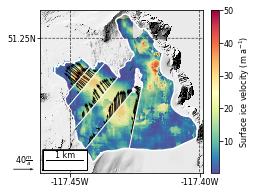

In [357]:
year =2018
I = np.abs(year - 2016) 
vf_list = ['illecillewaet_2016_all25m_vx.tif','illecillewaet_2017_all25m_vx.tif','illecillewaet_2018_all25m_vx.tif']
vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/' 
VX = vdir+ vf_list[I]
VY = vdir+ vf_list[I][:-7] + '_vy.tif' 

vy = salem.open_xr_dataset(VY);vy = vy.to_array(name='vy')
vx = salem.open_xr_dataset(VX);vx = vx.to_array(name='vx')
msk = salem.open_xr_dataset(path+'illecillewaet_2014_extent_5m.tif') 
msk_reproj = vy.salem.transform(msk); msk = msk_reproj.to_array(name='msk')
msk.data[msk.data<0.0]=np.nan

vz = vy
vz.data = np.sqrt(vx.data**2 + vz.data**2 )
vz.data[vz.data<0.01]=np.nan; #vz.data[vz.data>50.0]=np.nan
vz.data[msk.data!=1.0] = np.nan;
# np.count_nonzero(~np.isnan(vz.data))/np.count_nonzero(~np.isnan(msk))


font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1';pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1, figsize=cm2inch(8.5,6.5))
grid1 = mercator_grid(center_ll=(-117.43, 51.237), extent=(4400, 4400)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
# grid = vx.salem.grid  ##full view
sm1 = Map(grid1, countries=False)
sm1.set_lonlat_contours(interval=0)
sm1.set_scale_bar(location=(0.15, 0.08),add_bbox=True,bbox_dy=1.1,linewidth=1.0)
VZA=xr.DataArray(data=vz, coords=vz.coords, dims=vz.dims, name='VZA', attrs=vz.attrs) #,indexes=vx.indexes fastpath=False)

# VZA.data=VZA.data*(msk+1.0)
sm1.set_data(VZA) 

sm1.set_cmap("Spectral_r")
sm1.set_vmax(val=50.)
# sm1.set_vmin(val=0)
#      Change the lon-lat countour setting
sm1.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
sm1.set_topography(topo,  relief_factor=0.8)
sm1.set_shapefile(gdf, lw=1.5, color='w')
sm1.set_shapefile(gates, color='w', lw=1.1)
sm1.append_colorbar(ax=ax, pad=0.1, label='Surface ice velocity (m a$^{-1}$)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm1.plot(ax=ax)

u = df_agg.vx.values
v = df_agg.vy.values

X, Y = np.meshgrid(df_agg.lon,df_agg.lat)

# transform their coordinates to the map reference system and plot the arrows
xx, yy = sm1.grid.transform(df_agg.lon, df_agg.lat, crs=salem.wgs84)#sm1.grid.proj

# xx, yy = np.meshgrid(xx,yy)

# qu = ax.quiver(xx, yy, u, v)

###### start:stop:step
Q = ax.quiver(xx[::2], yy[::2], u[::2], v[::2])  #, pivot='mid')
qk = ax.quiverkey(Q, 0.07, 0.10, 40, r'$40 \frac{m}{a}$', labelpos='N', coordinates='figure', labelsep=0.025)



# Q = ax.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2], pivot='mid')
#Q= ax2.quiver(X[::3, ::3], Y[::3, ::3], U[::3, ::3], V[::3, ::3],pivot='mid', units='inches')

# X, Y = np.meshgrid(df_agg.lon,df_agg.lat)
# U = df_agg.vx.values
# V = df_agg.vy.values
# U,V = np.meshgrid(U, V)

# # Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
# Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')


fig.subplots_adjust(bottom=0.05, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_vel_gates_quiver'+str(year)+'.pdf', dpi=300)

In [ ]:
ITS_LIVE_mean = np.mean(VEL_LIST), np.std(VEL_LIST)
ITS_LIVE_mean

In [ ]:
VEL_LIST

In [ ]:
IND_V_mean = np.mean(VEL_LIST), np.std(VEL_LIST)
IND_V_mean

In [ ]:
VEL_LIST_indV=VEL_LIST
VEL_LIST_indV

In [ ]:
res = [i - j for i, j in zip(VEL_LIST_indV, VEL_LIST)] 
res2 =[i / j for i, j in zip(res, VEL_LIST_indV)]
np.mean(res2), np.std(res2)

In [ ]:
year=2018
VDIR = 'individual'  # 'average' or 'individual'
ITS_LIVE = True
I = np.abs(year - 2016)

if VDIR == 'individual':
#     vf_list = ['img1_20160912__img1_20170917_vmap_5m_35px_spm2/', 'img1_20160912__img1_20170917_vmap_5m_35px_spm2/',
#            'img1_20170521__img1_20180426_vmap_5m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/

#         vf_list = ['img1_20160912__img1_20170521_vmap_5m_35px_spm2/', 'img1_20160912__img1_20170521_vmap_5m_35px_spm2/',
#                'img1_20180426__img2_20181016_vmap_5m_35px_spm2/']##backups  img1_20170917__img1_20180426_vmap_5m_35px_spm2/
    vf_list = ['illecillewaet_2016_all25m_vx.tif','illecillewaet_2017_all25m_vx.tif','illecillewaet_2018_all25m_vx.tif']
#     vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/spm2/' + vf_list[I]
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/' 
#         VX = vdir+ vf_list[I][:-1] + '-F_vx.tif' 
#         VY = vdir+ vf_list[I][:-1] + '-F_vy.tif' 
    VX = vdir+ vf_list[I]
    VY = vdir+ vf_list[I][:-7] + '_vy.tif' 
    ITS = fl_path + 'ITS_LIVE/' + str(year) + '_illecillewaet_ITS_LIVE.tif'
else:
#         vf_list = ['illec_all_spm2_5m', 'illec_all_spm2_5m', 'illec_all_spm2_5m']
#         vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/spm2/'  
#         VX = vdir+ 'vx/' +vf_list[I] + '_vx.tif' 
#         VY = vdir+ 'vy/' +vf_list[I] + '_vy.tif'
    vf = 'illecillewaet_all_dem3m_'
    vdir = '/home/pelto/Desktop/velocity_mapping/' +glacier[gl] + '/3m/'  
    VX = vdir + vf + 'blur1_25m_vx_neg.tif' #'vx_best_neg_5m.tif'
    VY = vdir + vf + 'blur1_25m_vy.tif'
#         VM = vdir + vf + 'vm_5m.tif'
    ITS = fl_path + 'ITS_LIVE/' + str(year) + '_illecillewaet_ITS_LIVE.tif'

topo = path + '160912_illecillewaet_dem1_clip_master.tif'

vx = salem.open_xr_dataset(VX);vy = salem.open_xr_dataset(VY);vx = vx.to_array(name='vx');vy = vy.to_array(name='vy')
msk = salem.open_xr_dataset(fl_path + 'illec_all_glaciers_2016.tif') 
extent=salem.open_xr_dataset(path +'illecillewaet_2014_extent_5m.tif')

# msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
farin = salem.open_xr_dataset(farinotti)

H_opt = salem.open_xr_dataset(fl_path+'Illecillewaet_251sw_MAE_optimized.tif')#+'Illecillewaet101sw_MAE_optimized.tif') 

msk_reproj = vx.salem.transform(msk);msk = msk_reproj.to_array(name='msk')
extent_reproj=vx.salem.transform(extent); extent = extent_reproj.to_array(name='extent')
gpr_reproj = vx.salem.transform(gpr); gpr = gpr_reproj.to_array(name='gpr')
ITS = salem.open_xr_dataset(ITS); ITS_reproj = vx.salem.transform(ITS);ITS = ITS_reproj.to_array(name='ITS')

gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data<1.5] = 0.0   #not having any effect
VZ = np.sqrt(vx.data**2 + vy.data**2 )
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan

VZ_off_ice = VZ.copy()
VZ_off_ice[msk.data>0.0] = np.nan
# VZ_off_ice[VZ_off_ice==0.0] = np.nan
VZ[extent.data<1.0] = np.nan
DIFF = VZ - ITS
dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan


In [ ]:
fig3, ax3 = plt.subplots(1,1, sharex=True, sharey=True, figsize=(cm2inch(12, 12.))) 
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
VZ[VZ<0.50] = np.nan

sm.set_data(VZ-ITS) #, label='m')
sm.set_vmax(val=15.);sm.set_vmin(val=-15.);
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')
# off_ice_V = np.nanmean(VZ_off_ice)
diff = np.nanmean(VZ-ITS)
print(diff)
print(diff/np.nanmean(VZ))
# print(off_ice_V)
# print(np.nanstd(VZ_off_ice))
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()

In [ ]:
np.std([0.30,0.21,0.35])


In [ ]:
####### Net flux uncertainty #################
np.sum(new.sQout)/np.sum(new.Q_out)
print(np.mean([new.sBwe_opt,FG_all.sBwe_gpr,new.sBwe_F]))

In [ ]:
pd.set_option('display.max_rows', None)
new

In [225]:
residuals= [z_range_all,gpr_bdiff,farin_bdiff,opt_bdiff,obs_bin_all]

r = pd.DataFrame(list(zip(z_range_all,elev_all,gpr_bdiff,farin_bdiff,opt_bdiff,gpr_bd_fg,opt_bd_fg,farin_bd_fg,
                          obs_bin_all,obs_fg_all,obs_fg_all_med,gpr_bd_fg_med,opt_bd_fg_med,farin_bd_fg_med)), 
                  columns=['z_range_all','elev_all','gpr_bdiff','farin_bdiff','opt_bdiff','gpr_bd_fg','opt_bd_fg','farin_bd_fg',
                           'obs_bin_all','obs_fg_all','obs_fg_all_med','gpr_bd_fg_med','opt_bd_fg_med','farin_bd_fg_med']) 
r['zrel'] = r.elev_all-r.z_range_all.min()
r.zrel= r.zrel / r.zrel.max()

r['gpr_fr']=r.gpr_bdiff/np.abs(r.obs_bin_all);r['far_fr']=r.farin_bdiff/np.abs(r.obs_bin_all);
r['opt_fr']=r.opt_bdiff/np.abs(r.obs_bin_all); 
## for FG bins by mean
r['opt_bd_fr']=r.opt_bd_fg/np.abs(r.obs_fg_all)
r['farin_bd_fr']=r.farin_bd_fg/np.abs(r.obs_fg_all);r['gpr_bd_fr']=r.gpr_bd_fg/np.abs(r.obs_fg_all);
## for FG bins by mean
r['opt_bd_med_fr']=r.opt_bd_fg_med/np.abs(r.obs_fg_all_med)
r['farin_bd_med_fr']=r.farin_bd_fg_med/np.abs(r.obs_fg_all_med);r['gpr_bd_med_fr']=r.gpr_bd_fg_med/np.abs(r.obs_fg_all_med);

In [226]:
np.nanmin(dem.data[msk.data==1.0])

1848.8326

In [227]:
# DATA=[];D2=[]
# z=[]
# # s= [r.opt_bdiff, r.farin_bdiff,r.gpr_bdiff]
# s= [r.opt_bd_fg, r.farin_bd_fg,r.gpr_bd_fg]
# s1=[r.opt_bd_med_fr, r.farin_bd_med_fr,r.gpr_bd_med_fr]
# for i in range(3):
#     DATA.extend(s[i])
#     D2.extend(s1[i])
#     z.extend(r.zrel)
    
# DF = pd.DataFrame(list(zip(DATA,D2,z)),   columns=['r_data','r_frac','zrel'])
# DF.dropna(subset=['r_data'],inplace=True)
# # DF.r_frac[np.abs(DF.r_frac)>4]=np.nan;DF.dropna(subset=['r_frac'],inplace=True)
# print(len(DF))
# DF.r_data[np.abs(DF.r_frac)>0.5]=np.nan;DF.dropna(subset=['r_data'],inplace=True)
# print(len(DF))

In [228]:
# 1-(26/54)

In [229]:
y1=np.array([2016]*6);y2=np.array([2017]*6);y3=np.array([2018]*6);Years=np.concatenate([y1,y2,y3])
r['year']=Years
# r.z_range_all[r.z_range_all==2750.0]=np.nan;#
# for n in range(len(r)):
#     if (r.z_range_all[n]>2400) and (r.year[n]==2018):
#         r.z_range_all[n]=np.nan
#     if (r.z_range_all[n]>2750.0) and (r.year[n]==2017):
#         r.z_range_all[n]=np.nan
#     if (r.z_range_all[n]>2450.0 or r.z_range_all[n]==2550.0) and (r.year[n]==2017):
#         r.z_range_all[n]=np.nan

# # r.z_range_all[ & r.year<2018]=np.nan
r.dropna(subset=['z_range_all'],inplace=True)
# r

In [230]:
fig_path= '/home/pelto/Desktop/ice_flux/figures/'
with open(fig_path + glacier[gl]+'_residuals.pkl', 'wb') as f:    #_NOfirn
    pickle.dump(r, f)

In [239]:
import scipy.stats as stats
stats.f_oneway(obs_fg_all,gpr_all),stats.f_oneway(obs_fg_all,opt_all) ,stats.f_oneway(obs_fg_all,farin_all) 

(F_onewayResult(statistic=0.08820838656765408, pvalue=0.7682742536555284),
 F_onewayResult(statistic=0.18269146824258015, pvalue=0.6717653024361637),
 F_onewayResult(statistic=0.010139420990552272, pvalue=0.9203842759991278))

In [ ]:
AV=[]
for i in range(len(new)):
    AV.append(np.nanmean([new.b_fg_h[i]-new.Vfirn[i], new16.b_fg_h_gpr[i]-new16.Vfirn[i], new17.b_fg_hF[i]-new17.Vfirn[i]]))
AV

In [168]:
print('mean percent smb error:', round(np.nanmean([np.abs(new16.sBwe_F/new16.b_fg_weF),np.abs(new16.sBwe_gpr/new16.b_fg_we_gpr),
                                             np.abs(new16.sBwe_opt/new16.b_fg_we),np.abs(new17.sBwe_F/new17.b_fg_weF),np.abs(new17.sBwe_gpr/new17.b_fg_we_gpr),
                                             np.abs(new17.sBwe_opt/new17.b_fg_we),np.abs(new.sBwe_F/new.b_fg_weF),np.abs(new.sBwe_gpr/new.b_fg_we_gpr),
                                             np.abs(new.sBwe_opt/new.b_fg_we)]),2))

print('mean flux error:',round(np.nanmean([new16.spQo_gpr,new16.spQout,new16.spQoutF]),1))

mean_error= np.mean([new16.sBwe_opt.mean(),new16.sBwe_F.mean(),new16.sBwe_gpr.mean(),new17.sBwe_opt.mean(),
            new17.sBwe_F.mean(),new17.sBwe_gpr.mean(),new.sBwe_opt.mean(),new.sBwe_F.mean(),new.sBwe_gpr.mean()])
print('mean SMB error:', round(mean_error,2))

mean percent smb error: 1.98
mean flux error: 24.2
mean SMB error: 0.56


In [291]:
### cross section area comparison ###
R= np.sum(new.cr_area)/np.sum(new.cr_areaF)
Ri=new16.cr_area/new16.cr_area_gpr
R=R-1
print(R)
# R[R>0.4]=np.nan
R.mean()
GR=new.cr_area_gpr/new.cr_areaF

# GR=GR-1
print(GR)
GR.median()

0.3648710095792036
0         NaN
1    1.395786
2    1.095508
3    0.978317
4    1.412542
5    1.743346
dtype: float64


1.39578578629272

In [292]:
a=[];b=[];c=[]
for i in range(len(new.cr_area)-1):
    a.append(new.cr_area_gpr[i]/new.cr_area_gpr[i+1])
    b.append(new.cr_area[i]/new.cr_area[i+1])
    c.append(new.cr_areaF[i]/new.cr_areaF[i+1])
dcr=pd.DataFrame(list(zip(a,b,c)),columns=['a','b','c'])
dcr['ab']=1-dcr.a/dcr.b;dcr['bc']=1-dcr.b/dcr.c;dcr['ac']=1-dcr.a/dcr.c
dcr.ab.median(),dcr.bc.median(),dcr.ac.median()

(-0.1000502727441146, 0.12702149053722184, 0.034982457814228096)

In [293]:
dcr

,a,b,c,ab,bc,ac
0,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,0.563222,0.348925,0.442055,-0.614165,0.210676,-0.274100
2,0.653605,0.558374,0.583687,-0.170551,0.043367,-0.119787
3,0.704285,1.075863,1.016881,0.345376,-0.058003,0.307406
4,0.882826,0.857488,1.089576,-0.029549,0.213008,0.189752


In [188]:
GRi=new16.cr_area_gpr/new16.cr_area
GR= np.sum(new.cr_area_gpr)/np.sum(new.cr_area)
GR-1

-0.028957258220220217

In [192]:
np.nanmedian(D_all.vfg)

8.70550570568146

In [ ]:
np.mean([new.Q_netAF[0], new.Q_netA_gpr[0], new.Q_netA[0]])

In [ ]:
########## Calculate glacier-wide SMB and compare with field obs #######################
SMB = [new16.b_fg_we_gpr,new17.b_fg_we_gpr,new.b_fg_we_gpr, new16.b_fg_we,new17.b_fg_we,new.b_fg_we,
      new16.b_fg_weF,new17.b_fg_weF,new.b_fg_weF]
Bn=[]
for i in range(len(SMB)):
    MB=SMB[i]*new.dem_count
    A=np.sum(MB)/np.sum(new.dem_count)
    Bn.append(round(A,2))
field=[-0.19,-0.84,-1.05,-0.19,-0.84,-1.05,-0.19,-0.84,-1.05]

MB_df = pd.DataFrame(list(zip(field, Bn)), 
            columns=['field', 'flux_bn'])

MB_df['MBAL_diff']=MB_df.field-MB_df.flux_bn

print(MB_df.MBAL_diff.mean())
MB_df

In [ ]:
np.mean([new.dh_mean[0], new16.dh_mean[0], new17.dh_mean[0]])

In [ ]:
glacier

In [ ]:
fig_path= '/home/pelto/Desktop/ice_flux/figures/'

with open(fig_path + glacier[2]+'_vfg_all.pkl', 'wb') as f:
    pickle.dump(vfg_all, f)
with open(fig_path + glacier[2]+ '_gate_elev.pkl', 'wb') as f:
    pickle.dump(gate_elev, f)
new.to_csv(fig_path + glacier[2]+'_new_2018.csv')

# with open(fig_path + glacier[1] +'_vfg_all.pkl', 'rb') as f:
#     vfg_all = pickle.load(f)
# with open(fig_path + glacier[1] + 'gate_elev.pkl', 'rb') as f:
#     gates_elev = pickle.load(f)

In [ ]:
pd.set_option('display.max_columns', None)
new

In [ ]:
fig3, ax3 = plt.subplots(1,1, sharex=True, sharey=True, figsize=(2.85,2.75)) ##mass conservation plot

Yvv = [new.Q_netA_gpr, new.Q_netA, new.Q_netAF]
Yvv_lbl=[r'$V^{\uparrow}_{IPR}$',r'$V^{\uparrow}_{OGGM}$',r'$V^{\uparrow}_{Farin}$']

AX=ax3.twinx()
for i in range(3):
    ax3.scatter(new.dem_mean, Yvv[i], edgecolor='k', marker=sym[i+1], alpha=0.6, label=Yvv_lbl[i], s=35, 
                       color=color[i+1], zorder=2, linewidth=0.25)
meanlineprops = dict(linestyle='--', lw=1., color='#cb181d');medianprops = dict(linestyle='-', lw=1.,color='k')
BOXVEL=AX.boxplot(vfg_all,meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,
                  sym='', positions=[2188., 2288., 2351., 2440., 2517.,2536.,2565., 2591.],widths=25, zorder=1)

ax3.set_xticks([2100, 2200,  2300, 2400, 2500, 2600])  #, 2650])
ax3.set_xticklabels([2100, 2200,  2300, 2400, 2500, 2600]) 
ax3.set(xlim=(2090, 2650))
ax3.legend(loc='upper right', labelspacing=0.35)

fig3.text(0.005, 0.65, r'$V^{\uparrow}$' + '(m ice $a^{-1}$)',rotation=90) #transform=ax3.transAxes)
fig3.text(0.94, 0.7, 'Ice velocity (m $a^{-1}$)',rotation=90)

ax3.set_zorder(1)
ax3.patch.set_visible(False)

fig3.subplots_adjust(bottom=0.11, top=0.98, hspace=0.1, left=0.12, right=0.85, wspace=0.05)
fig3.savefig(fl_path + 'products/' + glacier[gl] + '_Velocities.pdf', dpi=300)

# Illec Stats

In [302]:
M= ['Observed','FG IPR','FG OGGM','FG Farinotti']
#################  LINEAR STATS ################
# method=[]
# for i in range(4):
#     method.extend(M)
# len(method)
# STATS=pd.DataFrame(list(zip(method,SL[:,0], SE[:,1], RSQ, RSR, NSE, PBias,ME,MAE)),  ## RLM_SL, RLM_SE, MSE_ABL,
#                      columns=['method','ALL', 'ALLse','RSQ', 'RSR', 'NSE', 'PBias','ME','MAE'])
# STATS.ALL=STATS.ALL*1000;STATS.ALLse=STATS.ALLse*1000;
# STATS

#################  PW STATS ################
# MSE_ABL,MSE_ACC, 'MSE_ABL','MSE_ACC'
method=[]
for i in range(4):
    method.extend(M)
len(method)
STATS=pd.DataFrame(list(zip(method,SL_L[:,0], SE_L[:,1],SL[:,0], SE[:,1],SL[:,1], SE[:,2], PBias,ME,MAE)), 
                     columns=['method','ALL','ALLse','ABL', 'ABLse', 'ACC', 'ACCse', 'PBias','ME','MAE'])
STATS.ALL=STATS.ALL*1000;STATS.ALLse=STATS.ALLse*1000;#STATS.ABL=STATS.ABL*1000;STATS.ABLse=STATS.ABLse*1000;
#STATS.ACC=STATS.ACC*1000;STATS.ACCse=STATS.ACCse*1000
STATS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,PBias,ME,MAE
0,Observed,12.608086,1.461869,0.016251,0.001013,0.004419,0.002634,0.000000,0.000000,0.000000
1,FG IPR,14.990666,2.605081,0.018398,0.004376,0.007332,0.011376,-40.384177,0.355515,0.489046
2,FG OGGM,14.507133,2.331874,0.016758,0.004188,0.009447,0.010889,-48.630095,0.428107,0.526640
3,FG Farinotti,13.022538,1.772616,0.016933,0.001925,0.004232,0.005004,-25.107906,0.221033,0.275834
4,Observed,12.386351,0.737749,0.012609,0.001063,0.010108,0.007378,0.000000,0.000000,0.000000
5,FG IPR,13.181210,1.622835,0.014991,0.001681,-0.005320,0.011659,-35.509752,0.483761,0.486409
6,FG OGGM,12.767851,2.612911,0.014188,0.003602,-0.001753,0.024984,-39.815340,0.542418,0.745157
7,FG Farinotti,11.425417,1.426225,0.013273,0.001188,-0.007460,0.008242,-26.273806,0.357937,0.434954
8,Observed,11.589634,2.095653,0.013907,0.002196,-0.011990,0.015189,0.000000,0.000000,0.000000
9,FG IPR,11.853258,1.927280,0.014139,0.001866,-0.011409,0.012908,25.237899,-0.338735,0.370975


In [303]:
STATS.ABL[STATS.method=='Observed']

0    0.016251
4    0.012609
8    0.013907
Name: ABL, dtype: float64

In [304]:
STATS.ACC.mean()/STATS.ABLse.mean()

-0.7020992832227129

In [305]:
# rng_ab=[];rng_ac=[]
# for m in M:
#     mn= STATS.ABL[STATS.method==m].min(); mx=STATS.ABL[STATS.method==m].max()
#     mnc= STATS.ACC[STATS.method==m].min(); mxc=STATS.ACC[STATS.method==m].max()
#     rng_ab.append(mn/mx);rng_ac.append(mnc/mxc);
# rng_ab, rng_ac

In [306]:
# np.mean(STATS.ABLse), np.mean(STATS.ACCse)

In [307]:
for m in M:
    L= STATS[STATS.method==m].values
    MEAN= np.nanmean(L[:,1:],axis=0)
    MEAN= np.insert(MEAN,0,m)
    STATS= STATS.append(dict(zip(STATS.columns, MEAN)),ignore_index=True)
STATS=STATS.round(2);STATS.ABLse=STATS.ABLse.round(1);STATS.ACCse=STATS.ACCse.round(1);STATS.ALLse=STATS.ALLse.round(1)
STATS.PBias=STATS.PBias.round(1)
STATS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,PBias,ME,MAE
0,Observed,12.61,1.5,0.02,0.0,0.00,0.0,0.0,0.00,0.00
1,FG IPR,14.99,2.6,0.02,0.0,0.01,0.0,-40.4,0.36,0.49
2,FG OGGM,14.51,2.3,0.02,0.0,0.01,0.0,-48.6,0.43,0.53
3,FG Farinotti,13.02,1.8,0.02,0.0,0.00,0.0,-25.1,0.22,0.28
4,Observed,12.39,0.7,0.01,0.0,0.01,0.0,0.0,0.00,0.00
5,FG IPR,13.18,1.6,0.01,0.0,-0.01,0.0,-35.5,0.48,0.49
6,FG OGGM,12.77,2.6,0.01,0.0,-0.00,0.0,-39.8,0.54,0.75
7,FG Farinotti,11.43,1.4,0.01,0.0,-0.01,0.0,-26.3,0.36,0.43
8,Observed,11.59,2.1,0.01,0.0,-0.01,0.0,0.0,0.00,0.00
9,FG IPR,11.85,1.9,0.01,0.0,-0.01,0.0,25.2,-0.34,0.37


In [311]:
S1=STATS.copy()
AB=[];AC=[];AL=[]
for i in range(len(S1)):
    AL.append(str(S1.ALL[i])+' $\pm$ '+str(S1.ALLse[i]))
    AB.append(str(S1.ABL[i])+' $\pm$ '+str(S1.ABLse[i]))
    AC.append((str(S1.ACC[i])+' $\pm$ '+str(S1.ACCse[i])))
S1.ABL=AB;S1.ACC=AC;S1.ALL=AL
S1.drop(columns=['ABLse','ABL','ACCse','ACC','ALLse'], inplace=True)
S1

,method,ALL,PBias,ME,MAE
0,Observed,12.61 $\pm$ 1.5,0.0,0.00,0.00
1,FG IPR,14.99 $\pm$ 2.6,-40.4,0.36,0.49
2,FG OGGM,14.51 $\pm$ 2.3,-48.6,0.43,0.53
3,FG Farinotti,13.02 $\pm$ 1.8,-25.1,0.22,0.28
4,Observed,12.39 $\pm$ 0.7,0.0,0.00,0.00
5,FG IPR,13.18 $\pm$ 1.6,-35.5,0.48,0.49
6,FG OGGM,12.77 $\pm$ 2.6,-39.8,0.54,0.75
7,FG Farinotti,11.43 $\pm$ 1.4,-26.3,0.36,0.43
8,Observed,11.59 $\pm$ 2.1,0.0,0.00,0.00
9,FG IPR,11.85 $\pm$ 1.9,25.2,-0.34,0.37


In [312]:
print(S1.to_latex(index=False)) 

\begin{tabular}{llrrr}
\toprule
       method &              ALL &  PBias &    ME &   MAE \\
\midrule
     Observed &  12.61 \$\textbackslash pm\$ 1.5 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  14.99 \$\textbackslash pm\$ 2.6 &  -40.4 &  0.36 &  0.49 \\
      FG OGGM &  14.51 \$\textbackslash pm\$ 2.3 &  -48.6 &  0.43 &  0.53 \\
 FG Farinotti &  13.02 \$\textbackslash pm\$ 1.8 &  -25.1 &  0.22 &  0.28 \\
     Observed &  12.39 \$\textbackslash pm\$ 0.7 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  13.18 \$\textbackslash pm\$ 1.6 &  -35.5 &  0.48 &  0.49 \\
      FG OGGM &  12.77 \$\textbackslash pm\$ 2.6 &  -39.8 &  0.54 &  0.75 \\
 FG Farinotti &  11.43 \$\textbackslash pm\$ 1.4 &  -26.3 &  0.36 &  0.43 \\
     Observed &  11.59 \$\textbackslash pm\$ 2.1 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  11.85 \$\textbackslash pm\$ 1.9 &   25.2 & -0.34 &  0.37 \\
      FG OGGM &  11.21 \$\textbackslash pm\$ 2.0 &   19.3 & -0.26 &  0.64 \\
 FG Farinotti &  10.13 \$\textbackslash pm\$ 1.4 & 

In [255]:
# STATS=STATS.append(Sall,ignore_index=True,sort=False)
# STATS=STATS.round(2)
# STATS
firn

False

In [256]:
STATS.to_pickle(fl_path+'illecillewaet_stats_ITS_LIVE_NOfirn.pkl')#'illecillewaet_LIN_NOfirn_stats.pkl') #_NOfirn

In [202]:
# LIN_firn_STATS=STATS
LIN_NOfirn_STATS=STATS
LIN_NOfirn_STATS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,PBias,ME,MAE
0,Observed,12.61,1.5,0.02,0.0,0.00,0.0,0.0,0.00,0.00
1,FG IPR,14.99,2.6,0.02,0.0,0.01,0.0,-40.4,0.36,0.49
2,FG OGGM,14.51,2.3,0.02,0.0,0.01,0.0,-48.6,0.43,0.53
3,FG Farinotti,13.02,1.8,0.02,0.0,0.00,0.0,-25.1,0.22,0.28
4,Observed,12.39,0.7,0.01,0.0,0.01,0.0,0.0,0.00,0.00
5,FG IPR,13.18,1.6,0.01,0.0,-0.01,0.0,-35.5,0.48,0.49
6,FG OGGM,12.77,2.6,0.01,0.0,-0.00,0.0,-39.8,0.54,0.75
7,FG Farinotti,11.43,1.4,0.01,0.0,-0.01,0.0,-26.3,0.36,0.43
8,Observed,11.59,2.1,0.01,0.0,-0.01,0.0,0.0,0.00,0.00
9,FG IPR,11.85,1.9,0.01,0.0,-0.01,0.0,25.2,-0.34,0.37


In [203]:
LFS=LIN_firn_STATS.tail(4) 
LFS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,PBias,ME,MAE
12,Observed,12.19,1.4,0.01,0.0,0.0,0.0,0.0,0.00,0.00
13,FG IPR,14.33,1.9,0.02,0.0,0.0,0.0,-7.9,0.06,0.49
14,FG OGGM,13.82,2.3,0.02,0.0,0.0,0.0,-14.1,0.13,0.66
15,FG Farinotti,12.52,1.3,0.01,0.0,-0.0,0.0,2.3,-0.05,0.42


In [204]:
LNFS=LIN_NOfirn_STATS.tail(4) 
LNFS

,method,ALL,ALLse,ABL,ABLse,ACC,ACCse,PBias,ME,MAE
12,Observed,12.19,1.4,0.01,0.0,0.0,0.0,0.0,0.00,0.00
13,FG IPR,13.34,2.0,0.02,0.0,-0.0,0.0,-16.9,0.17,0.45
14,FG OGGM,12.83,2.3,0.01,0.0,0.0,0.0,-23.0,0.24,0.64
15,FG Farinotti,11.53,1.5,0.01,0.0,-0.0,0.0,-6.6,0.05,0.42


In [208]:
LNFS['ALL_firn']=LFS.ALL
LNFS['pdiff_obs']=(LNFS.ALL-LNFS.ALL[12])/LNFS.ALL[12]
LNFS.pdiff_obs[1:].mean(),LNFS.pdiff_obs[1:].std(),

(0.03089964451736399, 0.076562072660916)

In [257]:
STATS['ALL_firn']=LFS.ALL
STATS['pdiff_obs']=(STATS.ALL-STATS.ALL[12])/STATS.ALL[12]
STATS.pdiff_obs[1:].mean(),STATS.pdiff_obs[1:].std(),

(-0.22444626743232152, 0.12771649418901967)

In [161]:
LNFS['ALL_firn']=LFS.ALL
LNFS['pdiff_obs']=(LNFS.ALL_firn-LNFS.ALL[12])/LNFS.ALL[12]
LNFS.pdiff_obs[1:].mean(),LNFS.pdiff_obs[1:].std(),

(0.11211375444353298, 0.076562072660916)

In [258]:
## Calc PBIAS for slopes
for i in range(3):
    D=STATS.ALL[STATS.method==(method[i+1])][:-1].values
    O=STATS.ALL[STATS.method=='Observed'][:-1].values
    e=evaluator(pbias, D,O)
    print(method[i+1],e )

FG IPR [28.47772615]
FG OGGM [23.91363761]
FG Farinotti [31.07406395]


In [205]:
STATS_LIN=STATS[['method','ALL','ALLse','PBias','ME','MAE']]
SL1=STATS_LIN.tail(4)
AB=[];AC=[];AL=[]
for i in SL1.index:
    AL.append(str(SL1.ALL[i])+' $\pm$ '+str(SL1.ALLse[i]))
SL1.ABL=AB;SL1.ACC=AC;SL1.ALL=AL
SL1.drop(columns=['ALLse'], inplace=True)
SL1
print(SL1.to_latex(index=False)) 
# SL1

\begin{tabular}{llrrr}
\toprule
       method &              ALL &  PBias &    ME &   MAE \\
\midrule
     Observed &  12.19 \$\textbackslash pm\$ 1.4 &    0.0 &  0.00 &  0.00 \\
       FG IPR &  13.34 \$\textbackslash pm\$ 2.0 &  -16.9 &  0.17 &  0.45 \\
      FG OGGM &  12.83 \$\textbackslash pm\$ 2.3 &  -23.0 &  0.24 &  0.64 \\
 FG Farinotti &  11.53 \$\textbackslash pm\$ 1.5 &   -6.6 &  0.05 &  0.42 \\
\bottomrule
\end{tabular}



In [261]:
1-STATS.ALL.tail(3).mean()/LNFS.ALL.mean()  #.MAE.mean()

0.29418053050043436

In [ ]:
# method=[]
# for i in range(4):
#     method.extend(M)
# len(method)
Sall=pd.DataFrame(list(zip(method,np.array(SLa)[:,0], np.array(SEa)[:,1],np.array(SLa)[:,1], np.array(SEa)[:,2])), 
                     columns=['method','ABL', 'ABLse', 'ACC', 'ACCse'])
Sall.ABL=Sall.ABL*1000;Sall.ABLse=Sall.ABLse*1000;Sall.ACC=Sall.ACC*1000;Sall.ACCse=Sall.ACCse*1000
Sall

In [ ]:
all_bin=x_bin
all_bin.append(y_bin)

In [324]:
all_bin=[obs.Ba[(obs.Year>2015) & (obs.Year < 2019)],gpr_all,opt_all,farin_all,obs.Elev[(obs.Year>2015) & (obs.Year < 2019)],elev_all,elev_all,elev_all]

In [325]:
with open(fl_path+ 'ALL_list.pkl', 'wb') as f:
    pickle.dump(all_bin, f)

In [327]:
np.mean([4.79,4.79,5.36]),np.std([4.79,4.79,5.36])

46.55332

In [ ]:
font = {'family' : 'Helvetica', 'weight' : 'normal',  'size'   : 8}
plt.rc('font', **font)
label=['Observed', 'FG IPR', 'FG OGGM', 'FG Farinotti']
obs = pd.read_csv(fl_path+ 'Illecillewaet_bdot.csv') 
obs=obs[obs.Year>2015]
obs.dropna(subset=['Ba'],inplace=True)
# obs=obs[obs.Year==2016 and obs.Year==2017 and obs.Year==2018]
SLa=[];SEa=[]
############## piecewise function ########################################         
fig3, ax3 = plt.subplots(1, sharex=True, sharey=True, figsize=(cm2inch(8.5, 8.5)))
y_bin=[obs.Ba,gpr_all,opt_all,farin_all]; x_bin=[obs.Elev,elev_all,elev_all,elev_all]
# y_bin=[obs_all,gpr_ALL,opt_all,farin_all]; x_bin=[z_range_all,zr_gpr,z_range_all,z_range_all]
x0=2500
def piecewise_linear(x, x0, y0, k1, k2):
   
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])   

for i in range(4):      
#     if i > 0 and year==2016:
#         x0=2470
#     else:
#         x0=2430
    ##pwlf
    Y=np.array(y_bin[i])
    X=np.array(x_bin[i])
    model = pwlf.PiecewiseLinFit(X, Y)
    breakpoints = [2040.,x0,2680.]
    model.fit_with_breaks(breakpoints)
    x_hat = np.arange(2040., 2660., 10.)
    y_hat = model.predict(x_hat)
    plt.plot(x_hat, y_hat, lw=1., alpha=1, color=color[i],zorder=1)
    SLa.append(model.slopes)
    SEa.append(model.standard_errors())
    
    x1=np.array(x_bin[i]); y1=np.array(y_bin[i])
    p , e = curve_fit(piecewise_linear, x1, y1 )
#     perr = np.sqrt(np.diag(e))
#     print(perr)
    xd = np.linspace(2040, 2660, 10)
#     ax3.plot(xd, piecewise_linear(xd, *p), color=color[i], label=label[i], lw=1.0)
    # mean square error of the lines
   

    MSE_res=[]
    for Line in range(2):
        Pred=[];Act=[]
        if Line ==0:
            INDEX= np.where(x1<x0)[0]
            for ix in INDEX:
                Pred.append( p[2]*x1[ix]+(p[1]-p[2]*x0))
                Act.append(y1[ix])

            MSE_res.append(MSE(Act,Pred))
        if Line==1:
            INDEX= np.where(x1>=x0)[0]
            for ix in INDEX:
                Pred.append( p[3]*x1[ix]+(p[1]-p[3]*x0))
                Act.append(y1[ix])

            MSE_res.append(MSE(Act,Pred))
    ax3.scatter(x_bin[i], y_bin[i], color=color[i], s=10, marker=sym[i], facecolors='none', lw=0.5, label=label[i],
               zorder=2,alpha=0.7)
#     meanlineprops = dict(linestyle='--', linewidth=1., color=color[i])
#     medianprops = dict(linestyle='-', linewidth=1, color=color[i])
#     if i == 1:
#         BOX2=ax3.boxplot(y_bin[i],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                     positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050],widths=75)
#     else:
#         BOX2=ax3.boxplot(y_bin[i],meanprops=meanlineprops,medianprops=medianprops,showmeans=True, meanline=True,sym='',
#                     positions=[1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050,3150,3250],widths=75)

#     ax3.text(0.2, ytxt[i], txt[i]+ ' L1: '+ str(np.round(p[2]*1000,2)) +' L2: ' + 
#                     str(np.round(p[3]*1000,2)) + ' AABR: ' + str(np.round(p[2]/p[3],2)),
#                      transform=ax3.transAxes)  
#     ax3.text(0.55, ytxt[i], txt[i] + ' L1: '+ str(round(SL[0]*1000,2))+u" \u00B1 "+ str(round(SE[1]*1000*1.96,2)) +' L2: ' + 
#                    str(round(SL[1]*1000,2))+u" \u00B1 "+ str(round(SE[2]*1000*1.96,2)) ,transform=ax3.transAxes) #+ ' AABR: ' + str(np.round(p[2]/p[3],2)),
                      
    ax3.legend(loc='best')
    ax3.axhline(linewidth=1., color='k', ls='--', alpha=a, zorder=0)
    ax3.set(ylim=(-8.5,3.2),xlim=(2030,2660),ylabel='Mass balance (m w.e.)',xlabel='Elevation (m a.s.l.)')
#         print(MSE_results)
fig3.savefig(fl_path + 'products/' + glacier[gl]+'_' + balance +'_all_years_combinedBIG.pdf', dpi=300)

In [ ]:
SLa, SEa

In [ ]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

y = np.array(obs_data.Ba)   #new.b_fg_we.values
x = np.array(obs_data.Elev) #new.dem_mean.values

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
#     return np.piecewise(x, [x < 0, x >= 0], [lambda x:k1*x + y0-k1*0, lambda x:k2*x + y0-k2*0])
p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(2000, 2800, 15)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))
plt.show

In [ ]:
FIT = np.polyfit(x,y,3)
poly = np.poly1d(FIT)
new_x = np.linspace(x[0], x[-1])
new_y = poly(new_x)
plt.plot(x, y, "o", new_x, new_y)
plt.show()
# plt.scatter(x,y)
FIT

In [ ]:
def piecewise_linear(x, x0, y0, k1, k2):
    x0=2400
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(2000, 2800, 15)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p), color='k')
plt.show

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# y = new.b_fg_we.values
y=np.array([9,-3,-5,-4,7,-2,-1,3,5,6])
x = new.dem_mean.values

Neg= np.where(y > 0 )[0]
breakpoint=np.where(Neg==min(Neg))[0][0]

C=0
while C==0:
    BP_check=Neg[breakpoint+1]-Neg[breakpoint]
    if BP_check >1:
        breakpoint= breakpoint+1
    else:
        C=1
    
BP=Neg[breakpoint]
first_y=y[:BP]
first_x=x[:BP]

second_y=y[BP:]
second_x=x[BP:]
        

In [ ]:
g=0,3
o=1,4
f=2,5
GPR_dat=[]; OPT_dat=[];FAR_dat=[]
for n in range(2):
    GPR_dat.append([NSE[g[n]],PBias[g[n]],RSR[g[n]]])
    OPT_dat.append([NSE[o[n]],PBias[o[n]],RSR[o[n]]])
    FAR_dat.append([NSE[f[n]],PBias[f[n]],RSR[f[n]]])


GPR_dat_FIN=np.mean(GPR_dat,axis=0)
OPT_dat_FIN=np.mean(OPT_dat,axis=0)
FAR_dat_FIN=np.mean(FAR_dat,axis=0)
    
    #     NSE.mean
# print(GPR_dat)
# print(OPT_dat)
# print(FAR_dat)

In [ ]:
gpr_bdiff = pd.Series(gpr_bdiff)
gpr_bdiff.dropna(inplace=True)
opt_bdiff = pd.Series(opt_bdiff)
opt_bdiff.dropna(inplace=True)
farin_bdiff = pd.Series(farin_bdiff)
farin_bdiff.dropna(inplace=True)

In [ ]:
gpr_bdiff = pd.Series(gpr_bdiff)

gpr_bdiff_abs = np.abs(gpr_bdiff)
opt_bdiff_abs = np.abs(opt_bdiff)
farin_bdiff_abs = np.abs(farin_bdiff)
m_gpr_bdiff = round(np.mean(gpr_bdiff),2)
ma_gpr_bdiff = round(np.mean(gpr_bdiff_abs),2)
s_gpr_bdiff = round(np.std(gpr_bdiff),2)
sa_gpr_bdiff = round(np.std(gpr_bdiff_abs),2)
m_opt_bdiff = round(np.mean(opt_bdiff),2)
ma_opt_bdiff = round(np.mean(opt_bdiff_abs),2)
s_opt_bdiff = round(np.std(opt_bdiff),2)
sa_opt_bdiff = round(np.std(opt_bdiff_abs),2)
m_far_bdiff = round(np.mean(farin_bdiff),2)
ma_far_bdiff = round(np.mean(farin_bdiff_abs),2)
s_far_bdiff = round(np.std(farin_bdiff),2)
sa_far_bdiff = round(np.std(farin_bdiff_abs),2)


print('mean gpr diff:', m_gpr_bdiff, '+/-',s_gpr_bdiff,', abs. diff mean:', ma_gpr_bdiff,'+/-',sa_gpr_bdiff)
print('mean opt diff:', m_opt_bdiff, '+/-',s_opt_bdiff,', abs. diff mean:', ma_opt_bdiff,'+/-',sa_opt_bdiff)
print('mean farin diff:', m_far_bdiff, '+/-',s_far_bdiff,', abs. diff mean:', ma_far_bdiff,'+/-',sa_far_bdiff)

mean_diff_std = np.round(np.mean([sa_gpr_bdiff, sa_opt_bdiff, sa_far_bdiff]),2) #np.round(np.std([m_gpr_bdiff, m_opt_bdiff, m_far_bdiff]),2)
mean_diff =  np.round(np.mean([m_gpr_bdiff, m_opt_bdiff, m_far_bdiff]),2)
meanabs_diff_std = np.round(np.mean([s_gpr_bdiff, s_opt_bdiff, s_far_bdiff]),2)#np.round(np.std([ma_gpr_bdiff, ma_opt_bdiff, ma_far_bdiff]),2)
meanabs_diff =  np.round(np.mean([ma_gpr_bdiff, ma_opt_bdiff, ma_far_bdiff]),2)

print(mean_diff, '+/-', mean_diff_std)
print(meanabs_diff, '+/-', meanabs_diff_std)

In [ ]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()
print(B_opt)
print(B_gpr)

## Plot flux gates as cross-sections

In [ ]:
for i in range(D.id.nunique()):
    print(i)

In [ ]:
df_agg[df_agg.id==0.0]

In [ ]:

df_agg = df_agg.astype({"id": int})


In [ ]:
df_agg[df_agg.id==0]

In [ ]:
with open(fl_path + glacier[2]+'_df_agg.pkl', 'wb') as f:
    pickle.dump(df_agg, f)

In [ ]:
for i in range(D.id.nunique()):
    print(i)

In [ ]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.'
pylab.rcParams['ytick.major.pad']='1.'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
div=1000
letter=['M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']

obs_H = df_agg.copy()
obs_H = obs_H.dropna(subset=['gpr']) #, inplace=True)   

fig, ax = plt.subplots(2,6, figsize=(7.08,2.5))
for i in range(D.id.nunique()):
    K=df_agg[df_agg.id==i].sort_values(by=['distance'])
    O=obs_H[obs_H.id==i].sort_values(by=['distance'])
    
    # plot glacier surface
    ax[j,k].plot(K.distance, (K.dem/div), color='#43a2ca', alpha=a, 
                 label='Ice surface')
    
    #plot gpr thickness gates
    gpr=(O.dem/div)-(O.gpr/div)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(O.distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Observed bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    
    ax[j,k].plot(K.distance, (K.dem/div)-(K.H_opt/div), 
                 ls='--', c='r', alpha=a, label='OGGM bed')  #marker='o')
    
    ##plot Farinotti thickness gates
    ax[j,k].plot(K.distance, (K.dem/div)-(K.farin_corr/div), 
                 ls='--', c='salmon', alpha=a, label='Farinotti et al. (2019) bed')  #marker='o')
    ax[1,4].axis('off')

#     if i <= 2:
#         ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50/div))
#     else:
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(100/div))
    ax[j,k].tick_params(which='major', length=2)
    if i == 7:
        ax[j,k].text(0.9, 0.08, letter[i], transform=ax[j,k].transAxes, fontweight='bold', verticalalignment='center', horizontalalignment='center')
    else:
        ax[j,k].text(0.1, 0.08, letter[i], transform=ax[j,k].transAxes, fontweight='bold', verticalalignment='center', horizontalalignment='center')
#     ax[0,0].set_ylim(2.0, 2.12)
    ax[0,1].set_ylim(2.18, 2.35)
    ax[0,5].set_xlim(-100, 2200)
#     if i > 8:
    ax[1,2].axis('off');ax[1,3].axis('off'); ax[1,4].axis('off'); ax[1,5].axis('off')
    n += 1

    k += 1
    if n == 6: 
        j += 1
        k = 0  
         
    ax[0,5].legend(loc=4,  bbox_to_anchor=(0.35, -1.1),)
    ax[0,0].set_ylabel('Altitude (m a.s.l.)')
# fig.text(0.005, 0.65, 'Altitude (m a.s.l.)', rotation=90)
# fig.text(0.48, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.115, top=0.98, left=0.055, right=0.99, wspace=0.25, hspace=0.18) 

plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates_trial.pdf', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

In [ ]:
font = {'family' : 'Helvetica', 'weight' : 'normal', 'size'   : 8}
thick=H_opt.copy();thick.data[thick.data<0.1] = np.nan
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1'
pylab.rcParams['ytick.major.pad']='1'

fig, ax = plt.subplots(1,figsize=cm2inch(8.5,6.6))

grid = mercator_grid(center_ll=(-117.428, 51.238), extent=(4100, 4200)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
# grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
b = sm.set_geometry(linewidth=0.1, alpha=0.8, facecolor='p') ############???????????????????
sm.set_scale_bar(location=(0.16, 0.93), add_bbox=True, bbox_dy=0.95, bbox_kwargs=b, linewidth=1.2)

VZA=xr.DataArray(data=VZ, coords=vx.coords, dims=vx.dims, name='VZA', attrs=vx.attrs) #,indexes=vx.indexes fastpath=False)

VZA.data=VZA.data*(msk)
VZA.data[VZA.data>50.]=np.nan

sm.set_data(VZA) 
sm.set_vmax(val=50.)
#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, lw=0.75, linestyles='--', colors='0.25')
off_ice_V = np.nanmean(VZ_off_ice)
print(off_ice_V)
print(np.nanstd(VZ_off_ice))
sm.set_topography(topo,  relief_factor=0.9)
shpf14 = '/home/pelto/GIS/outlines/Illec2014.shp'  
gdf = salem.read_shapefile(shpf14)
sm.set_shapefile(gdf, lw=1.5, color='w',)
sm.set_cmap("Spectral_r")
sm.set_shapefile(gates, color='w', lw=1.0)
sm.append_colorbar(ax=ax, pad=0.1, label='Ice velocity (m yr$^{-1}$)') #'Ice Velocity (m yr$^-1$)')#, cbar_title='Ice Velocity (m yr$^-1$)')
sm.plot(ax=ax)

# sm.visualize(addcbar=True, cbar_title='Ice Velocity (m yr$^-1$)')
# plt.append_colorbar(ax, label='Velocity (m yr-1)')
fig.subplots_adjust(bottom=0.04, top=0.99, left=0.14, right=0.88) #, wspace=0.22, hspace=0.15
plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_velocity_gates.pdf', dpi=300)
# plt.savefig(fl_path+ 'products/'+ glacier[gl]+ '_thickness.png', dpi=300)
plt.show()

In [ ]:
## trying to fill nan velocity points
#     import more_itertools as mit
#     #IDS= unique(D.id)

# import more_itertools as mit
# IDS= unique(D.id)

# Sorted_D= D.sort_values(['id', 'distance'], ascending=[True,True])
# Missing_V= np.where(Sorted_D['vz'].isnull()==True)[0]
# Grouped_MV= [list(group) for group in mit.consecutive_groups(Missing_V)]
# for i in Grouped_MV:
#     if len(i)==1:
#         index=i[0]
#         replace= np.mean([Sorted_D['vz'][index-1],Sorted_D['vz'][index+1]])
#         Sorted_D['vz'][index]= replace
#     else:
#         start_index=i[0]
#         end_index=i[-1]
#         replace= np.mean([Sorted_D['vz'][start_index-4:start_index-1],Sorted_D['vz'][end_index+1:end_index+4]])
#         Sorted_D['vx'][i]=replace
    